# **Importing necessary libraries**

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\asus\appdata\local\temp\pip-req-build-hb2lmwsk
  Resolved https://github.com/tensorflow/examples.git to commit 0b14ce1c88537b94772cc99d995d936417be6f5d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\ASUS\AppData\Local\Temp\pip-req-build-hb2lmwsk'


In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

# **Load the dataset**

In [4]:
dataset = "E:/Datasets/FoodSeg103/Images"

In [ ]:
train_df = tf.data.Dataset.list_files(dataset + '/img_dir/train/*.jpg')
val_df = tf.data.Dataset.list_files(dataset + '/ann_dir/train/*.jpg')

 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [9]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = train_df.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = val_df.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [11]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


   8192/9406464 [..............................] - ETA: 0s


9406464/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

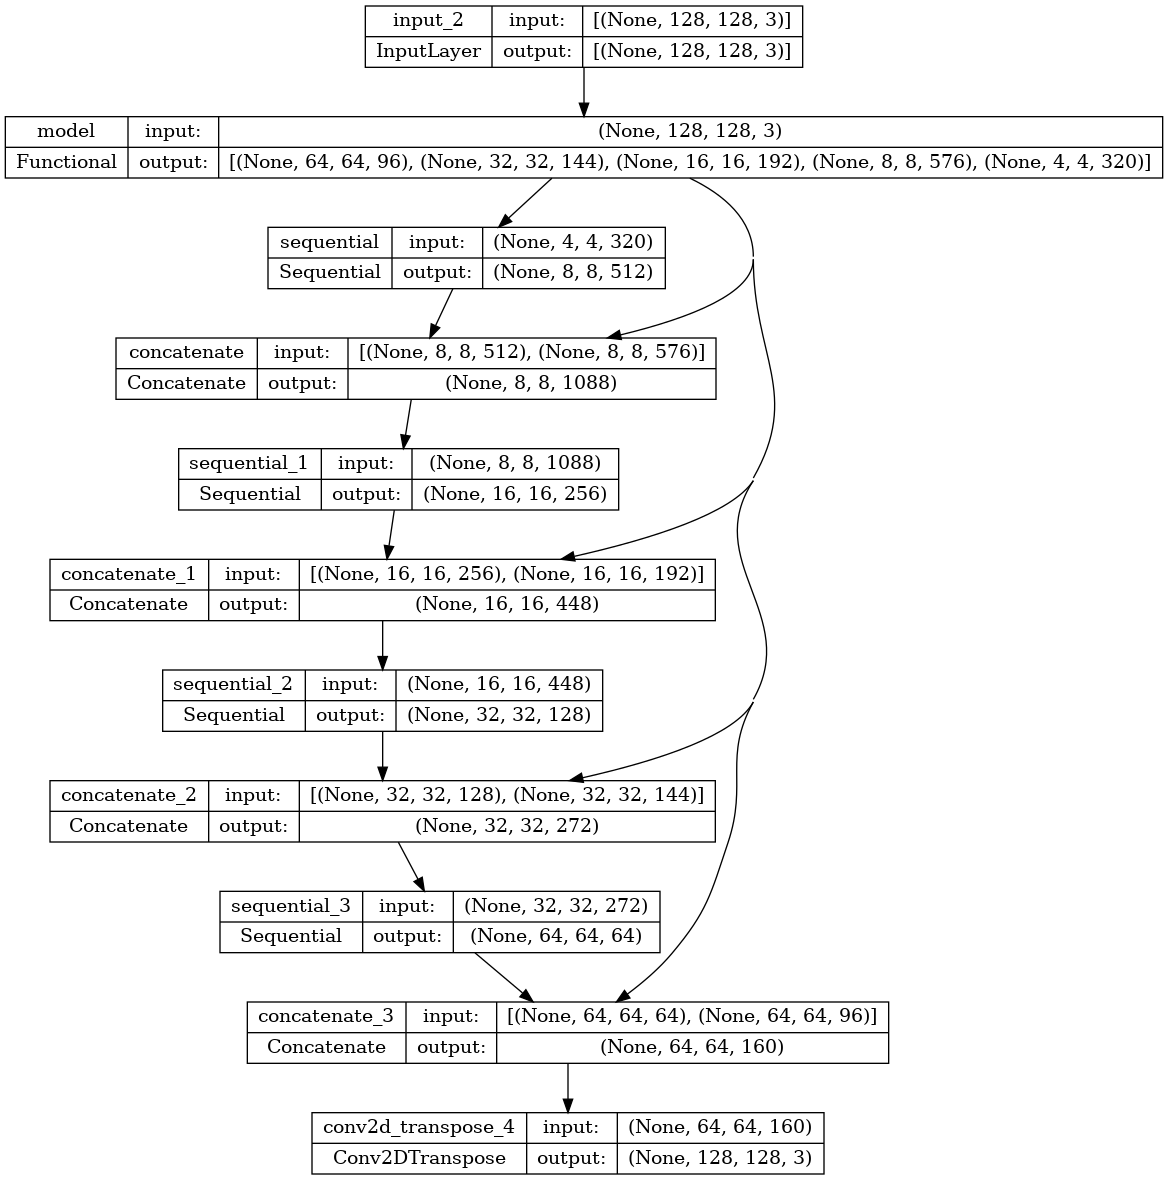

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

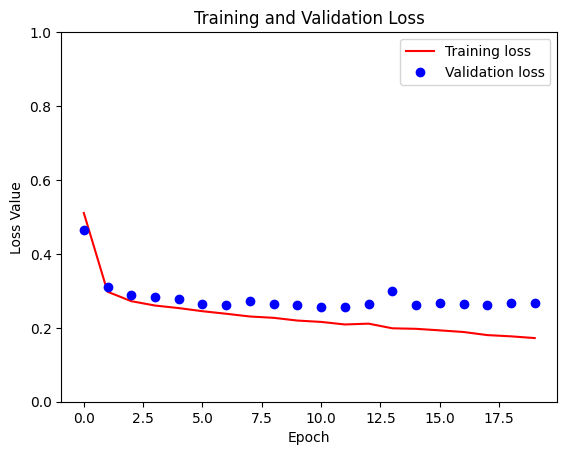

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20



 1/57 [..............................] - ETA: 1:37 - loss: 0.2568 - accuracy: 0.9329


 2/57 [>.............................] - ETA: 7s - loss: 0.2440 - accuracy: 0.9330  


 3/57 [>.............................] - ETA: 6s - loss: 0.2391 - accuracy: 0.9315


 4/57 [=>............................] - ETA: 6s - loss: 0.2425 - accuracy: 0.9287


 5/57 [=>............................] - ETA: 6s - loss: 0.2408 - accuracy: 0.9276


 6/57 [==>...........................] - ETA: 5s - loss: 0.2453 - accuracy: 0.9254


 7/57 [==>...........................] - ETA: 5s - loss: 0.2462 - accuracy: 0.9251


 8/57 [===>..........................] - ETA: 5s - loss: 0.2483 - accuracy: 0.9249


 9/57 [===>..........................] - ETA: 5s - loss: 0.2469 - accuracy: 0.9255


10/57 [====>.........................] - ETA: 5s - loss: 0.2475 - accuracy: 0.9252


11/57 [====>.........................] - ETA: 5s - loss: 0.2488 - accuracy: 0.9247


12/57 [=====>........................] - ETA: 5s - loss: 0.2502 - accuracy: 0.9239


13/57 [=====>........................] - ETA: 5s - loss: 0.2511 - accuracy: 0.9236


14/57 [======>.......................] - ETA: 4s - loss: 0.2527 - accuracy: 0.9232


15/57 [======>.......................] - ETA: 4s - loss: 0.2530 - accuracy: 0.9234


16/57 [=======>......................] - ETA: 4s - loss: 0.2532 - accuracy: 0.9236


17/57 [=======>......................] - ETA: 4s - loss: 0.2529 - accuracy: 0.9238


18/57 [========>.....................] - ETA: 4s - loss: 0.2569 - accuracy: 0.9224


19/57 [=========>....................] - ETA: 4s - loss: 0.2565 - accuracy: 0.9223


20/57 [=========>....................] - ETA: 4s - loss: 0.2581 - accuracy: 0.9219


21/57 [==========>...................] - ETA: 4s - loss: 0.2580 - accuracy: 0.9221


22/57 [==========>...................] - ETA: 4s - loss: 0.2576 - accuracy: 0.9223


23/57 [===========>..................] - ETA: 3s - loss: 0.2573 - accuracy: 0.9224


24/57 [===========>..................] - ETA: 3s - loss: 0.2566 - accuracy: 0.9224


25/57 [============>.................] - ETA: 3s - loss: 0.2580 - accuracy: 0.9220


26/57 [============>.................] - ETA: 3s - loss: 0.2586 - accuracy: 0.9219


27/57 [=============>................] - ETA: 3s - loss: 0.2590 - accuracy: 0.9217


28/57 [=============>................] - ETA: 3s - loss: 0.2601 - accuracy: 0.9216


29/57 [==============>...............] - ETA: 3s - loss: 0.2605 - accuracy: 0.9215


30/57 [==============>...............] - ETA: 3s - loss: 0.2608 - accuracy: 0.9215


31/57 [===============>..............] - ETA: 2s - loss: 0.2630 - accuracy: 0.9212


32/57 [===============>..............] - ETA: 2s - loss: 0.2635 - accuracy: 0.9210


33/57 [================>.............] - ETA: 2s - loss: 0.2632 - accuracy: 0.9211


34/57 [================>.............] - ETA: 2s - loss: 0.2636 - accuracy: 0.9211


35/57 [=================>............] - ETA: 2s - loss: 0.2637 - accuracy: 0.9211


36/57 [=================>............] - ETA: 2s - loss: 0.2634 - accuracy: 0.9211


37/57 [==================>...........] - ETA: 2s - loss: 0.2645 - accuracy: 0.9209


38/57 [===================>..........] - ETA: 2s - loss: 0.2647 - accuracy: 0.9208


39/57 [===================>..........] - ETA: 2s - loss: 0.2648 - accuracy: 0.9208


40/57 [====================>.........] - ETA: 1s - loss: 0.2648 - accuracy: 0.9208


41/57 [====================>.........] - ETA: 1s - loss: 0.2651 - accuracy: 0.9207


42/57 [=====================>........] - ETA: 1s - loss: 0.2651 - accuracy: 0.9205


43/57 [=====================>........] - ETA: 1s - loss: 0.2648 - accuracy: 0.9206


44/57 [======================>.......] - ETA: 1s - loss: 0.2652 - accuracy: 0.9206


45/57 [======================>.......] - ETA: 1s - loss: 0.2655 - accuracy: 0.9206


46/57 [=======================>......] - ETA: 1s - loss: 0.2652 - accuracy: 0.9206


47/57 [=======================>......] - ETA: 1s - loss: 0.2651 - accuracy: 0.9205


48/57 [========================>.....] - ETA: 1s - loss: 0.2649 - accuracy: 0.9205


49/57 [========================>.....] - ETA: 0s - loss: 0.2656 - accuracy: 0.9204


50/57 [=========================>....] - ETA: 0s - loss: 0.2657 - accuracy: 0.9204


51/57 [=========================>....] - ETA: 0s - loss: 0.2659 - accuracy: 0.9204


52/57 [==========================>...] - ETA: 0s - loss: 0.2652 - accuracy: 0.9206


53/57 [==========================>...] - ETA: 0s - loss: 0.2652 - accuracy: 0.9206


54/57 [===========================>..] - ETA: 0s - loss: 0.2650 - accuracy: 0.9207


55/57 [===========================>..] - ETA: 0s - loss: 0.2652 - accuracy: 0.9206


56/57 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9205


57/57 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9205


57/57 [==============================] - 8s 114ms/step - loss: 0.2655 - accuracy: 0.9205


Epoch 2/20



 1/57 [..............................] - ETA: 3s - loss: 0.2659 - accuracy: 0.9198


 2/57 [>.............................] - ETA: 6s - loss: 0.2584 - accuracy: 0.9229


 3/57 [>.............................] - ETA: 6s - loss: 0.2524 - accuracy: 0.9232


 4/57 [=>............................] - ETA: 6s - loss: 0.2515 - accuracy: 0.9224


 5/57 [=>............................] - ETA: 5s - loss: 0.2573 - accuracy: 0.9215


 6/57 [==>...........................] - ETA: 5s - loss: 0.2569 - accuracy: 0.9220


 7/57 [==>...........................] - ETA: 5s - loss: 0.2548 - accuracy: 0.9225


 8/57 [===>..........................] - ETA: 5s - loss: 0.2543 - accuracy: 0.9226


 9/57 [===>..........................] - ETA: 5s - loss: 0.2535 - accuracy: 0.9228


10/57 [====>.........................] - ETA: 5s - loss: 0.2520 - accuracy: 0.9232


11/57 [====>.........................] - ETA: 5s - loss: 0.2514 - accuracy: 0.9236


12/57 [=====>........................] - ETA: 5s - loss: 0.2517 - accuracy: 0.9236


13/57 [=====>........................] - ETA: 5s - loss: 0.2524 - accuracy: 0.9236


14/57 [======>.......................] - ETA: 4s - loss: 0.2525 - accuracy: 0.9233


15/57 [======>.......................] - ETA: 4s - loss: 0.2522 - accuracy: 0.9234


16/57 [=======>......................] - ETA: 4s - loss: 0.2518 - accuracy: 0.9235


17/57 [=======>......................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9235


18/57 [========>.....................] - ETA: 4s - loss: 0.2518 - accuracy: 0.9236


19/57 [=========>....................] - ETA: 4s - loss: 0.2525 - accuracy: 0.9234


20/57 [=========>....................] - ETA: 4s - loss: 0.2519 - accuracy: 0.9236


21/57 [==========>...................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9236


22/57 [==========>...................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9235


23/57 [===========>..................] - ETA: 3s - loss: 0.2517 - accuracy: 0.9235


24/57 [===========>..................] - ETA: 3s - loss: 0.2521 - accuracy: 0.9234


25/57 [============>.................] - ETA: 3s - loss: 0.2522 - accuracy: 0.9234


26/57 [============>.................] - ETA: 3s - loss: 0.2521 - accuracy: 0.9235


27/57 [=============>................] - ETA: 3s - loss: 0.2512 - accuracy: 0.9238


28/57 [=============>................] - ETA: 3s - loss: 0.2515 - accuracy: 0.9236


29/57 [==============>...............] - ETA: 3s - loss: 0.2515 - accuracy: 0.9235


30/57 [==============>...............] - ETA: 3s - loss: 0.2518 - accuracy: 0.9235


31/57 [===============>..............] - ETA: 2s - loss: 0.2520 - accuracy: 0.9233


32/57 [===============>..............] - ETA: 2s - loss: 0.2516 - accuracy: 0.9234


33/57 [================>.............] - ETA: 2s - loss: 0.2515 - accuracy: 0.9234


34/57 [================>.............] - ETA: 2s - loss: 0.2509 - accuracy: 0.9237


35/57 [=================>............] - ETA: 2s - loss: 0.2512 - accuracy: 0.9237


36/57 [=================>............] - ETA: 2s - loss: 0.2507 - accuracy: 0.9238


37/57 [==================>...........] - ETA: 2s - loss: 0.2512 - accuracy: 0.9236


38/57 [===================>..........] - ETA: 2s - loss: 0.2513 - accuracy: 0.9236


39/57 [===================>..........] - ETA: 2s - loss: 0.2508 - accuracy: 0.9237


40/57 [====================>.........] - ETA: 1s - loss: 0.2509 - accuracy: 0.9236


41/57 [====================>.........] - ETA: 1s - loss: 0.2515 - accuracy: 0.9235


42/57 [=====================>........] - ETA: 1s - loss: 0.2513 - accuracy: 0.9236


43/57 [=====================>........] - ETA: 1s - loss: 0.2513 - accuracy: 0.9236


44/57 [======================>.......] - ETA: 1s - loss: 0.2510 - accuracy: 0.9237


45/57 [======================>.......] - ETA: 1s - loss: 0.2510 - accuracy: 0.9237


46/57 [=======================>......] - ETA: 1s - loss: 0.2519 - accuracy: 0.9235


47/57 [=======================>......] - ETA: 1s - loss: 0.2519 - accuracy: 0.9235


48/57 [========================>.....] - ETA: 1s - loss: 0.2522 - accuracy: 0.9234


49/57 [========================>.....] - ETA: 0s - loss: 0.2525 - accuracy: 0.9234


50/57 [=========================>....] - ETA: 0s - loss: 0.2529 - accuracy: 0.9233


51/57 [=========================>....] - ETA: 0s - loss: 0.2528 - accuracy: 0.9233


52/57 [==========================>...] - ETA: 0s - loss: 0.2532 - accuracy: 0.9231


53/57 [==========================>...] - ETA: 0s - loss: 0.2535 - accuracy: 0.9230


54/57 [===========================>..] - ETA: 0s - loss: 0.2539 - accuracy: 0.9230


55/57 [===========================>..] - ETA: 0s - loss: 0.2545 - accuracy: 0.9228


56/57 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9227


57/57 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9226


57/57 [==============================] - 6s 115ms/step - loss: 0.2553 - accuracy: 0.9226


Epoch 3/20



 1/57 [..............................] - ETA: 6s - loss: 0.2499 - accuracy: 0.9245


 2/57 [>.............................] - ETA: 3s - loss: 0.2499 - accuracy: 0.9249


 3/57 [>.............................] - ETA: 4s - loss: 0.2510 - accuracy: 0.9235


 4/57 [=>............................] - ETA: 5s - loss: 0.2582 - accuracy: 0.9203


 5/57 [=>............................] - ETA: 5s - loss: 0.2572 - accuracy: 0.9209


 6/57 [==>...........................] - ETA: 5s - loss: 0.2577 - accuracy: 0.9215


 7/57 [==>...........................] - ETA: 5s - loss: 0.2566 - accuracy: 0.9216


 8/57 [===>..........................] - ETA: 5s - loss: 0.2541 - accuracy: 0.9225


 9/57 [===>..........................] - ETA: 5s - loss: 0.2557 - accuracy: 0.9222


10/57 [====>.........................] - ETA: 5s - loss: 0.2530 - accuracy: 0.9227


11/57 [====>.........................] - ETA: 5s - loss: 0.2530 - accuracy: 0.9226


12/57 [=====>........................] - ETA: 4s - loss: 0.2526 - accuracy: 0.9230


13/57 [=====>........................] - ETA: 4s - loss: 0.2532 - accuracy: 0.9228


14/57 [======>.......................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9233


15/57 [======>.......................] - ETA: 4s - loss: 0.2511 - accuracy: 0.9235


16/57 [=======>......................] - ETA: 4s - loss: 0.2515 - accuracy: 0.9230


17/57 [=======>......................] - ETA: 4s - loss: 0.2504 - accuracy: 0.9235


18/57 [========>.....................] - ETA: 4s - loss: 0.2490 - accuracy: 0.9239


19/57 [=========>....................] - ETA: 4s - loss: 0.2479 - accuracy: 0.9242


20/57 [=========>....................] - ETA: 4s - loss: 0.2470 - accuracy: 0.9245


21/57 [==========>...................] - ETA: 4s - loss: 0.2476 - accuracy: 0.9243


22/57 [==========>...................] - ETA: 3s - loss: 0.2465 - accuracy: 0.9245


23/57 [===========>..................] - ETA: 3s - loss: 0.2466 - accuracy: 0.9245


24/57 [===========>..................] - ETA: 3s - loss: 0.2458 - accuracy: 0.9247


25/57 [============>.................] - ETA: 3s - loss: 0.2451 - accuracy: 0.9250


26/57 [============>.................] - ETA: 3s - loss: 0.2448 - accuracy: 0.9251


27/57 [=============>................] - ETA: 3s - loss: 0.2449 - accuracy: 0.9250


28/57 [=============>................] - ETA: 3s - loss: 0.2451 - accuracy: 0.9250


29/57 [==============>...............] - ETA: 3s - loss: 0.2448 - accuracy: 0.9250


30/57 [==============>...............] - ETA: 3s - loss: 0.2445 - accuracy: 0.9251


31/57 [===============>..............] - ETA: 2s - loss: 0.2445 - accuracy: 0.9251


32/57 [===============>..............] - ETA: 2s - loss: 0.2446 - accuracy: 0.9252


33/57 [================>.............] - ETA: 2s - loss: 0.2440 - accuracy: 0.9254


34/57 [================>.............] - ETA: 2s - loss: 0.2431 - accuracy: 0.9256


35/57 [=================>............] - ETA: 2s - loss: 0.2430 - accuracy: 0.9256


36/57 [=================>............] - ETA: 2s - loss: 0.2428 - accuracy: 0.9256


37/57 [==================>...........] - ETA: 2s - loss: 0.2425 - accuracy: 0.9258


38/57 [===================>..........] - ETA: 2s - loss: 0.2421 - accuracy: 0.9259


39/57 [===================>..........] - ETA: 2s - loss: 0.2418 - accuracy: 0.9259


40/57 [====================>.........] - ETA: 1s - loss: 0.2417 - accuracy: 0.9259


41/57 [====================>.........] - ETA: 1s - loss: 0.2416 - accuracy: 0.9259


42/57 [=====================>........] - ETA: 1s - loss: 0.2412 - accuracy: 0.9261


43/57 [=====================>........] - ETA: 1s - loss: 0.2413 - accuracy: 0.9261


44/57 [======================>.......] - ETA: 1s - loss: 0.2414 - accuracy: 0.9260


45/57 [======================>.......] - ETA: 1s - loss: 0.2413 - accuracy: 0.9259


46/57 [=======================>......] - ETA: 1s - loss: 0.2416 - accuracy: 0.9258


47/57 [=======================>......] - ETA: 1s - loss: 0.2411 - accuracy: 0.9260


48/57 [========================>.....] - ETA: 1s - loss: 0.2409 - accuracy: 0.9261


49/57 [========================>.....] - ETA: 0s - loss: 0.2417 - accuracy: 0.9259


50/57 [=========================>....] - ETA: 0s - loss: 0.2417 - accuracy: 0.9258


51/57 [=========================>....] - ETA: 0s - loss: 0.2418 - accuracy: 0.9258


52/57 [==========================>...] - ETA: 0s - loss: 0.2419 - accuracy: 0.9258


53/57 [==========================>...] - ETA: 0s - loss: 0.2418 - accuracy: 0.9258


54/57 [===========================>..] - ETA: 0s - loss: 0.2420 - accuracy: 0.9258


55/57 [===========================>..] - ETA: 0s - loss: 0.2421 - accuracy: 0.9258


56/57 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9259


57/57 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9258


57/57 [==============================] - 7s 114ms/step - loss: 0.2420 - accuracy: 0.9258


Epoch 4/20



 1/57 [..............................] - ETA: 6s - loss: 0.2385 - accuracy: 0.9245


 2/57 [>.............................] - ETA: 6s - loss: 0.2701 - accuracy: 0.9187


 3/57 [>.............................] - ETA: 4s - loss: 0.2658 - accuracy: 0.9189


 4/57 [=>............................] - ETA: 5s - loss: 0.2744 - accuracy: 0.9178


 5/57 [=>............................] - ETA: 5s - loss: 0.2703 - accuracy: 0.9192


 6/57 [==>...........................] - ETA: 5s - loss: 0.2619 - accuracy: 0.9213


 7/57 [==>...........................] - ETA: 5s - loss: 0.2608 - accuracy: 0.9212


 8/57 [===>..........................] - ETA: 5s - loss: 0.2610 - accuracy: 0.9210


 9/57 [===>..........................] - ETA: 5s - loss: 0.2590 - accuracy: 0.9216


10/57 [====>.........................] - ETA: 5s - loss: 0.2558 - accuracy: 0.9225


11/57 [====>.........................] - ETA: 5s - loss: 0.2562 - accuracy: 0.9226


12/57 [=====>........................] - ETA: 4s - loss: 0.2548 - accuracy: 0.9231


13/57 [=====>........................] - ETA: 4s - loss: 0.2554 - accuracy: 0.9230


14/57 [======>.......................] - ETA: 4s - loss: 0.2538 - accuracy: 0.9232


15/57 [======>.......................] - ETA: 4s - loss: 0.2526 - accuracy: 0.9234


16/57 [=======>......................] - ETA: 4s - loss: 0.2512 - accuracy: 0.9238


17/57 [=======>......................] - ETA: 4s - loss: 0.2504 - accuracy: 0.9238


18/57 [========>.....................] - ETA: 4s - loss: 0.2494 - accuracy: 0.9241


19/57 [=========>....................] - ETA: 4s - loss: 0.2492 - accuracy: 0.9241


20/57 [=========>....................] - ETA: 4s - loss: 0.2485 - accuracy: 0.9243


21/57 [==========>...................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9244


22/57 [==========>...................] - ETA: 3s - loss: 0.2470 - accuracy: 0.9245


23/57 [===========>..................] - ETA: 3s - loss: 0.2462 - accuracy: 0.9247


24/57 [===========>..................] - ETA: 3s - loss: 0.2473 - accuracy: 0.9244


25/57 [============>.................] - ETA: 3s - loss: 0.2468 - accuracy: 0.9247


26/57 [============>.................] - ETA: 3s - loss: 0.2461 - accuracy: 0.9250


27/57 [=============>................] - ETA: 3s - loss: 0.2456 - accuracy: 0.9252


28/57 [=============>................] - ETA: 3s - loss: 0.2459 - accuracy: 0.9251


29/57 [==============>...............] - ETA: 3s - loss: 0.2452 - accuracy: 0.9252


30/57 [==============>...............] - ETA: 3s - loss: 0.2447 - accuracy: 0.9253


31/57 [===============>..............] - ETA: 2s - loss: 0.2442 - accuracy: 0.9254


32/57 [===============>..............] - ETA: 2s - loss: 0.2441 - accuracy: 0.9255


33/57 [================>.............] - ETA: 2s - loss: 0.2436 - accuracy: 0.9256


34/57 [================>.............] - ETA: 2s - loss: 0.2433 - accuracy: 0.9257


35/57 [=================>............] - ETA: 2s - loss: 0.2432 - accuracy: 0.9258


36/57 [=================>............] - ETA: 2s - loss: 0.2431 - accuracy: 0.9258


37/57 [==================>...........] - ETA: 2s - loss: 0.2423 - accuracy: 0.9259


38/57 [===================>..........] - ETA: 2s - loss: 0.2426 - accuracy: 0.9258


39/57 [===================>..........] - ETA: 2s - loss: 0.2422 - accuracy: 0.9259


40/57 [====================>.........] - ETA: 1s - loss: 0.2415 - accuracy: 0.9261


41/57 [====================>.........] - ETA: 1s - loss: 0.2411 - accuracy: 0.9263


42/57 [=====================>........] - ETA: 1s - loss: 0.2403 - accuracy: 0.9265


43/57 [=====================>........] - ETA: 1s - loss: 0.2396 - accuracy: 0.9266


44/57 [======================>.......] - ETA: 1s - loss: 0.2392 - accuracy: 0.9267


45/57 [======================>.......] - ETA: 1s - loss: 0.2390 - accuracy: 0.9267


46/57 [=======================>......] - ETA: 1s - loss: 0.2392 - accuracy: 0.9266


47/57 [=======================>......] - ETA: 1s - loss: 0.2400 - accuracy: 0.9264


48/57 [========================>.....] - ETA: 1s - loss: 0.2400 - accuracy: 0.9264


49/57 [========================>.....] - ETA: 0s - loss: 0.2396 - accuracy: 0.9266


50/57 [=========================>....] - ETA: 0s - loss: 0.2396 - accuracy: 0.9266


51/57 [=========================>....] - ETA: 0s - loss: 0.2399 - accuracy: 0.9265


52/57 [==========================>...] - ETA: 0s - loss: 0.2399 - accuracy: 0.9265


53/57 [==========================>...] - ETA: 0s - loss: 0.2397 - accuracy: 0.9265


54/57 [===========================>..] - ETA: 0s - loss: 0.2396 - accuracy: 0.9266


55/57 [===========================>..] - ETA: 0s - loss: 0.2394 - accuracy: 0.9266


56/57 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9265


57/57 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9266


57/57 [==============================] - 7s 115ms/step - loss: 0.2394 - accuracy: 0.9266


Epoch 5/20



 1/57 [..............................] - ETA: 6s - loss: 0.2335 - accuracy: 0.9272


 2/57 [>.............................] - ETA: 6s - loss: 0.2454 - accuracy: 0.9226


 3/57 [>.............................] - ETA: 6s - loss: 0.2487 - accuracy: 0.9228


 4/57 [=>............................] - ETA: 5s - loss: 0.2550 - accuracy: 0.9210


 5/57 [=>............................] - ETA: 5s - loss: 0.2571 - accuracy: 0.9216


 6/57 [==>...........................] - ETA: 5s - loss: 0.2523 - accuracy: 0.9233


 7/57 [==>...........................] - ETA: 5s - loss: 0.2491 - accuracy: 0.9243


 8/57 [===>..........................] - ETA: 5s - loss: 0.2462 - accuracy: 0.9247


 9/57 [===>..........................] - ETA: 5s - loss: 0.2446 - accuracy: 0.9250


10/57 [====>.........................] - ETA: 5s - loss: 0.2439 - accuracy: 0.9250


11/57 [====>.........................] - ETA: 5s - loss: 0.2434 - accuracy: 0.9251


12/57 [=====>........................] - ETA: 4s - loss: 0.2412 - accuracy: 0.9257


13/57 [=====>........................] - ETA: 4s - loss: 0.2411 - accuracy: 0.9258


14/57 [======>.......................] - ETA: 4s - loss: 0.2400 - accuracy: 0.9263


15/57 [======>.......................] - ETA: 4s - loss: 0.2397 - accuracy: 0.9265


16/57 [=======>......................] - ETA: 4s - loss: 0.2394 - accuracy: 0.9266


17/57 [=======>......................] - ETA: 4s - loss: 0.2375 - accuracy: 0.9272


18/57 [========>.....................] - ETA: 4s - loss: 0.2379 - accuracy: 0.9268


19/57 [=========>....................] - ETA: 4s - loss: 0.2374 - accuracy: 0.9267


20/57 [=========>....................] - ETA: 4s - loss: 0.2362 - accuracy: 0.9272


21/57 [==========>...................] - ETA: 4s - loss: 0.2351 - accuracy: 0.9276


22/57 [==========>...................] - ETA: 3s - loss: 0.2346 - accuracy: 0.9278


23/57 [===========>..................] - ETA: 3s - loss: 0.2338 - accuracy: 0.9279


24/57 [===========>..................] - ETA: 3s - loss: 0.2332 - accuracy: 0.9280


25/57 [============>.................] - ETA: 3s - loss: 0.2326 - accuracy: 0.9281


26/57 [============>.................] - ETA: 3s - loss: 0.2330 - accuracy: 0.9279


27/57 [=============>................] - ETA: 3s - loss: 0.2328 - accuracy: 0.9279


28/57 [=============>................] - ETA: 3s - loss: 0.2322 - accuracy: 0.9281


29/57 [==============>...............] - ETA: 3s - loss: 0.2322 - accuracy: 0.9281


30/57 [==============>...............] - ETA: 3s - loss: 0.2322 - accuracy: 0.9281


31/57 [===============>..............] - ETA: 2s - loss: 0.2322 - accuracy: 0.9281


32/57 [===============>..............] - ETA: 2s - loss: 0.2319 - accuracy: 0.9282


33/57 [================>.............] - ETA: 2s - loss: 0.2316 - accuracy: 0.9283


34/57 [================>.............] - ETA: 2s - loss: 0.2310 - accuracy: 0.9285


35/57 [=================>............] - ETA: 2s - loss: 0.2304 - accuracy: 0.9286


36/57 [=================>............] - ETA: 2s - loss: 0.2302 - accuracy: 0.9287


37/57 [==================>...........] - ETA: 2s - loss: 0.2297 - accuracy: 0.9288


38/57 [===================>..........] - ETA: 2s - loss: 0.2299 - accuracy: 0.9287


39/57 [===================>..........] - ETA: 2s - loss: 0.2294 - accuracy: 0.9288


40/57 [====================>.........] - ETA: 1s - loss: 0.2289 - accuracy: 0.9289


41/57 [====================>.........] - ETA: 1s - loss: 0.2289 - accuracy: 0.9290


42/57 [=====================>........] - ETA: 1s - loss: 0.2286 - accuracy: 0.9291


43/57 [=====================>........] - ETA: 1s - loss: 0.2286 - accuracy: 0.9290


44/57 [======================>.......] - ETA: 1s - loss: 0.2285 - accuracy: 0.9291


45/57 [======================>.......] - ETA: 1s - loss: 0.2285 - accuracy: 0.9291


46/57 [=======================>......] - ETA: 1s - loss: 0.2282 - accuracy: 0.9291


47/57 [=======================>......] - ETA: 1s - loss: 0.2277 - accuracy: 0.9292


48/57 [========================>.....] - ETA: 1s - loss: 0.2274 - accuracy: 0.9293


49/57 [========================>.....] - ETA: 0s - loss: 0.2274 - accuracy: 0.9293


50/57 [=========================>....] - ETA: 0s - loss: 0.2278 - accuracy: 0.9292


51/57 [=========================>....] - ETA: 0s - loss: 0.2279 - accuracy: 0.9292


52/57 [==========================>...] - ETA: 0s - loss: 0.2279 - accuracy: 0.9292


53/57 [==========================>...] - ETA: 0s - loss: 0.2280 - accuracy: 0.9291


54/57 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9291


55/57 [===========================>..] - ETA: 0s - loss: 0.2275 - accuracy: 0.9293


56/57 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9293


57/57 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9293


57/57 [==============================] - 7s 115ms/step - loss: 0.2273 - accuracy: 0.9293


Epoch 6/20



 1/57 [..............................] - ETA: 6s - loss: 0.2142 - accuracy: 0.9315


 2/57 [>.............................] - ETA: 6s - loss: 0.2079 - accuracy: 0.9342


 3/57 [>.............................] - ETA: 6s - loss: 0.2113 - accuracy: 0.9333


 4/57 [=>............................] - ETA: 6s - loss: 0.2150 - accuracy: 0.9326


 5/57 [=>............................] - ETA: 5s - loss: 0.2150 - accuracy: 0.9327


 6/57 [==>...........................] - ETA: 5s - loss: 0.2168 - accuracy: 0.9320


 7/57 [==>...........................] - ETA: 5s - loss: 0.2166 - accuracy: 0.9321


 8/57 [===>..........................] - ETA: 5s - loss: 0.2161 - accuracy: 0.9322


 9/57 [===>..........................] - ETA: 5s - loss: 0.2154 - accuracy: 0.9328


10/57 [====>.........................] - ETA: 5s - loss: 0.2165 - accuracy: 0.9325


11/57 [====>.........................] - ETA: 5s - loss: 0.2166 - accuracy: 0.9322


12/57 [=====>........................] - ETA: 4s - loss: 0.2159 - accuracy: 0.9321


13/57 [=====>........................] - ETA: 4s - loss: 0.2150 - accuracy: 0.9324


14/57 [======>.......................] - ETA: 4s - loss: 0.2147 - accuracy: 0.9326


15/57 [======>.......................] - ETA: 4s - loss: 0.2146 - accuracy: 0.9326


16/57 [=======>......................] - ETA: 4s - loss: 0.2137 - accuracy: 0.9330


17/57 [=======>......................] - ETA: 4s - loss: 0.2130 - accuracy: 0.9332


18/57 [========>.....................] - ETA: 4s - loss: 0.2127 - accuracy: 0.9335


19/57 [=========>....................] - ETA: 4s - loss: 0.2126 - accuracy: 0.9335


20/57 [=========>....................] - ETA: 4s - loss: 0.2129 - accuracy: 0.9331


21/57 [==========>...................] - ETA: 4s - loss: 0.2123 - accuracy: 0.9332


22/57 [==========>...................] - ETA: 3s - loss: 0.2120 - accuracy: 0.9334


23/57 [===========>..................] - ETA: 3s - loss: 0.2122 - accuracy: 0.9334


24/57 [===========>..................] - ETA: 3s - loss: 0.2136 - accuracy: 0.9333


25/57 [============>.................] - ETA: 3s - loss: 0.2134 - accuracy: 0.9333


26/57 [============>.................] - ETA: 3s - loss: 0.2138 - accuracy: 0.9331


27/57 [=============>................] - ETA: 3s - loss: 0.2146 - accuracy: 0.9328


28/57 [=============>................] - ETA: 3s - loss: 0.2150 - accuracy: 0.9327


29/57 [==============>...............] - ETA: 3s - loss: 0.2145 - accuracy: 0.9329


30/57 [==============>...............] - ETA: 3s - loss: 0.2145 - accuracy: 0.9330


31/57 [===============>..............] - ETA: 2s - loss: 0.2144 - accuracy: 0.9331


32/57 [===============>..............] - ETA: 2s - loss: 0.2139 - accuracy: 0.9332


33/57 [================>.............] - ETA: 2s - loss: 0.2147 - accuracy: 0.9329


34/57 [================>.............] - ETA: 2s - loss: 0.2146 - accuracy: 0.9328


35/57 [=================>............] - ETA: 2s - loss: 0.2148 - accuracy: 0.9327


36/57 [=================>............] - ETA: 2s - loss: 0.2149 - accuracy: 0.9328


37/57 [==================>...........] - ETA: 2s - loss: 0.2152 - accuracy: 0.9327


38/57 [===================>..........] - ETA: 2s - loss: 0.2153 - accuracy: 0.9327


39/57 [===================>..........] - ETA: 2s - loss: 0.2146 - accuracy: 0.9329


40/57 [====================>.........] - ETA: 1s - loss: 0.2141 - accuracy: 0.9329


41/57 [====================>.........] - ETA: 1s - loss: 0.2140 - accuracy: 0.9329


42/57 [=====================>........] - ETA: 1s - loss: 0.2143 - accuracy: 0.9327


43/57 [=====================>........] - ETA: 1s - loss: 0.2142 - accuracy: 0.9328


44/57 [======================>.......] - ETA: 1s - loss: 0.2138 - accuracy: 0.9329


45/57 [======================>.......] - ETA: 1s - loss: 0.2141 - accuracy: 0.9329


46/57 [=======================>......] - ETA: 1s - loss: 0.2142 - accuracy: 0.9328


47/57 [=======================>......] - ETA: 1s - loss: 0.2140 - accuracy: 0.9329


48/57 [========================>.....] - ETA: 1s - loss: 0.2140 - accuracy: 0.9329


49/57 [========================>.....] - ETA: 0s - loss: 0.2140 - accuracy: 0.9329


50/57 [=========================>....] - ETA: 0s - loss: 0.2139 - accuracy: 0.9329


51/57 [=========================>....] - ETA: 0s - loss: 0.2141 - accuracy: 0.9328


52/57 [==========================>...] - ETA: 0s - loss: 0.2141 - accuracy: 0.9328


53/57 [==========================>...] - ETA: 0s - loss: 0.2141 - accuracy: 0.9328


54/57 [===========================>..] - ETA: 0s - loss: 0.2140 - accuracy: 0.9329


55/57 [===========================>..] - ETA: 0s - loss: 0.2142 - accuracy: 0.9329


56/57 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9328


57/57 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9328


57/57 [==============================] - 7s 115ms/step - loss: 0.2143 - accuracy: 0.9328


Epoch 7/20



 1/57 [..............................] - ETA: 6s - loss: 0.2178 - accuracy: 0.9291


 2/57 [>.............................] - ETA: 6s - loss: 0.2175 - accuracy: 0.9310


 3/57 [>.............................] - ETA: 6s - loss: 0.2211 - accuracy: 0.9311


 4/57 [=>............................] - ETA: 6s - loss: 0.2172 - accuracy: 0.9329


 5/57 [=>............................] - ETA: 6s - loss: 0.2131 - accuracy: 0.9341


 6/57 [==>...........................] - ETA: 5s - loss: 0.2158 - accuracy: 0.9333


 7/57 [==>...........................] - ETA: 5s - loss: 0.2150 - accuracy: 0.9328


 8/57 [===>..........................] - ETA: 5s - loss: 0.2148 - accuracy: 0.9328


 9/57 [===>..........................] - ETA: 5s - loss: 0.2150 - accuracy: 0.9330


10/57 [====>.........................] - ETA: 5s - loss: 0.2140 - accuracy: 0.9333


11/57 [====>.........................] - ETA: 5s - loss: 0.2137 - accuracy: 0.9334


12/57 [=====>........................] - ETA: 4s - loss: 0.2129 - accuracy: 0.9336


13/57 [=====>........................] - ETA: 4s - loss: 0.2120 - accuracy: 0.9337


14/57 [======>.......................] - ETA: 4s - loss: 0.2123 - accuracy: 0.9335


15/57 [======>.......................] - ETA: 4s - loss: 0.2121 - accuracy: 0.9334


16/57 [=======>......................] - ETA: 4s - loss: 0.2123 - accuracy: 0.9333


17/57 [=======>......................] - ETA: 4s - loss: 0.2124 - accuracy: 0.9335


18/57 [========>.....................] - ETA: 4s - loss: 0.2119 - accuracy: 0.9337


19/57 [=========>....................] - ETA: 4s - loss: 0.2121 - accuracy: 0.9336


20/57 [=========>....................] - ETA: 4s - loss: 0.2117 - accuracy: 0.9336


21/57 [==========>...................] - ETA: 4s - loss: 0.2119 - accuracy: 0.9335


22/57 [==========>...................] - ETA: 3s - loss: 0.2120 - accuracy: 0.9336


23/57 [===========>..................] - ETA: 3s - loss: 0.2117 - accuracy: 0.9336


24/57 [===========>..................] - ETA: 3s - loss: 0.2118 - accuracy: 0.9336


25/57 [============>.................] - ETA: 3s - loss: 0.2116 - accuracy: 0.9336


26/57 [============>.................] - ETA: 3s - loss: 0.2112 - accuracy: 0.9338


27/57 [=============>................] - ETA: 3s - loss: 0.2109 - accuracy: 0.9340


28/57 [=============>................] - ETA: 3s - loss: 0.2116 - accuracy: 0.9338


29/57 [==============>...............] - ETA: 3s - loss: 0.2119 - accuracy: 0.9335


30/57 [==============>...............] - ETA: 3s - loss: 0.2120 - accuracy: 0.9334


31/57 [===============>..............] - ETA: 2s - loss: 0.2116 - accuracy: 0.9335


32/57 [===============>..............] - ETA: 2s - loss: 0.2112 - accuracy: 0.9337


33/57 [================>.............] - ETA: 2s - loss: 0.2112 - accuracy: 0.9337


34/57 [================>.............] - ETA: 2s - loss: 0.2112 - accuracy: 0.9337


35/57 [=================>............] - ETA: 2s - loss: 0.2107 - accuracy: 0.9339


36/57 [=================>............] - ETA: 2s - loss: 0.2111 - accuracy: 0.9337


37/57 [==================>...........] - ETA: 2s - loss: 0.2112 - accuracy: 0.9337


38/57 [===================>..........] - ETA: 2s - loss: 0.2110 - accuracy: 0.9337


39/57 [===================>..........] - ETA: 2s - loss: 0.2109 - accuracy: 0.9337


40/57 [====================>.........] - ETA: 1s - loss: 0.2106 - accuracy: 0.9339


41/57 [====================>.........] - ETA: 1s - loss: 0.2107 - accuracy: 0.9340


42/57 [=====================>........] - ETA: 1s - loss: 0.2108 - accuracy: 0.9339


43/57 [=====================>........] - ETA: 1s - loss: 0.2106 - accuracy: 0.9339


44/57 [======================>.......] - ETA: 1s - loss: 0.2103 - accuracy: 0.9339


45/57 [======================>.......] - ETA: 1s - loss: 0.2102 - accuracy: 0.9340


46/57 [=======================>......] - ETA: 1s - loss: 0.2101 - accuracy: 0.9340


47/57 [=======================>......] - ETA: 1s - loss: 0.2098 - accuracy: 0.9340


48/57 [========================>.....] - ETA: 1s - loss: 0.2097 - accuracy: 0.9341


49/57 [========================>.....] - ETA: 0s - loss: 0.2098 - accuracy: 0.9341


50/57 [=========================>....] - ETA: 0s - loss: 0.2094 - accuracy: 0.9342


51/57 [=========================>....] - ETA: 0s - loss: 0.2095 - accuracy: 0.9342


52/57 [==========================>...] - ETA: 0s - loss: 0.2093 - accuracy: 0.9342


53/57 [==========================>...] - ETA: 0s - loss: 0.2093 - accuracy: 0.9342


54/57 [===========================>..] - ETA: 0s - loss: 0.2093 - accuracy: 0.9342


55/57 [===========================>..] - ETA: 0s - loss: 0.2093 - accuracy: 0.9342


56/57 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9343


57/57 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9342


57/57 [==============================] - 7s 115ms/step - loss: 0.2093 - accuracy: 0.9342


Epoch 8/20



 1/57 [..............................] - ETA: 6s - loss: 0.2041 - accuracy: 0.9327


 2/57 [>.............................] - ETA: 6s - loss: 0.2085 - accuracy: 0.9327


 3/57 [>.............................] - ETA: 6s - loss: 0.2039 - accuracy: 0.9350


 4/57 [=>............................] - ETA: 6s - loss: 0.2020 - accuracy: 0.9360


 5/57 [=>............................] - ETA: 5s - loss: 0.2020 - accuracy: 0.9358


 6/57 [==>...........................] - ETA: 5s - loss: 0.2102 - accuracy: 0.9336


 7/57 [==>...........................] - ETA: 5s - loss: 0.2099 - accuracy: 0.9337


 8/57 [===>..........................] - ETA: 5s - loss: 0.2093 - accuracy: 0.9342


 9/57 [===>..........................] - ETA: 5s - loss: 0.2077 - accuracy: 0.9350


10/57 [====>.........................] - ETA: 5s - loss: 0.2077 - accuracy: 0.9350


11/57 [====>.........................] - ETA: 5s - loss: 0.2065 - accuracy: 0.9351


12/57 [=====>........................] - ETA: 4s - loss: 0.2070 - accuracy: 0.9348


13/57 [=====>........................] - ETA: 4s - loss: 0.2070 - accuracy: 0.9347


14/57 [======>.......................] - ETA: 4s - loss: 0.2064 - accuracy: 0.9348


15/57 [======>.......................] - ETA: 4s - loss: 0.2068 - accuracy: 0.9348


16/57 [=======>......................] - ETA: 4s - loss: 0.2051 - accuracy: 0.9354


17/57 [=======>......................] - ETA: 4s - loss: 0.2044 - accuracy: 0.9355


18/57 [========>.....................] - ETA: 4s - loss: 0.2044 - accuracy: 0.9355


19/57 [=========>....................] - ETA: 4s - loss: 0.2038 - accuracy: 0.9357


20/57 [=========>....................] - ETA: 4s - loss: 0.2030 - accuracy: 0.9359


21/57 [==========>...................] - ETA: 4s - loss: 0.2027 - accuracy: 0.9360


22/57 [==========>...................] - ETA: 3s - loss: 0.2031 - accuracy: 0.9358


23/57 [===========>..................] - ETA: 3s - loss: 0.2025 - accuracy: 0.9360


24/57 [===========>..................] - ETA: 3s - loss: 0.2023 - accuracy: 0.9360


25/57 [============>.................] - ETA: 3s - loss: 0.2018 - accuracy: 0.9362


26/57 [============>.................] - ETA: 3s - loss: 0.2013 - accuracy: 0.9363


27/57 [=============>................] - ETA: 3s - loss: 0.2012 - accuracy: 0.9363


28/57 [=============>................] - ETA: 3s - loss: 0.2013 - accuracy: 0.9361


29/57 [==============>...............] - ETA: 3s - loss: 0.2010 - accuracy: 0.9363


30/57 [==============>...............] - ETA: 3s - loss: 0.2007 - accuracy: 0.9364


31/57 [===============>..............] - ETA: 2s - loss: 0.2004 - accuracy: 0.9365


32/57 [===============>..............] - ETA: 2s - loss: 0.2004 - accuracy: 0.9366


33/57 [================>.............] - ETA: 2s - loss: 0.2006 - accuracy: 0.9365


34/57 [================>.............] - ETA: 2s - loss: 0.2003 - accuracy: 0.9365


35/57 [=================>............] - ETA: 2s - loss: 0.2002 - accuracy: 0.9365


36/57 [=================>............] - ETA: 2s - loss: 0.2002 - accuracy: 0.9365


37/57 [==================>...........] - ETA: 2s - loss: 0.1998 - accuracy: 0.9366


38/57 [===================>..........] - ETA: 2s - loss: 0.1998 - accuracy: 0.9367


39/57 [===================>..........] - ETA: 2s - loss: 0.1997 - accuracy: 0.9367


40/57 [====================>.........] - ETA: 1s - loss: 0.1992 - accuracy: 0.9368


41/57 [====================>.........] - ETA: 1s - loss: 0.1990 - accuracy: 0.9369


42/57 [=====================>........] - ETA: 1s - loss: 0.1993 - accuracy: 0.9367


43/57 [=====================>........] - ETA: 1s - loss: 0.1992 - accuracy: 0.9368


44/57 [======================>.......] - ETA: 1s - loss: 0.1989 - accuracy: 0.9369


45/57 [======================>.......] - ETA: 1s - loss: 0.1988 - accuracy: 0.9370


46/57 [=======================>......] - ETA: 1s - loss: 0.1987 - accuracy: 0.9370


47/57 [=======================>......] - ETA: 1s - loss: 0.1990 - accuracy: 0.9369


48/57 [========================>.....] - ETA: 1s - loss: 0.1992 - accuracy: 0.9368


49/57 [========================>.....] - ETA: 0s - loss: 0.1992 - accuracy: 0.9368


50/57 [=========================>....] - ETA: 0s - loss: 0.1990 - accuracy: 0.9368


51/57 [=========================>....] - ETA: 0s - loss: 0.1989 - accuracy: 0.9369


52/57 [==========================>...] - ETA: 0s - loss: 0.1985 - accuracy: 0.9370


53/57 [==========================>...] - ETA: 0s - loss: 0.1986 - accuracy: 0.9370


54/57 [===========================>..] - ETA: 0s - loss: 0.1989 - accuracy: 0.9368


55/57 [===========================>..] - ETA: 0s - loss: 0.1990 - accuracy: 0.9368


56/57 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9367


57/57 [==============================] - ETA: 0s - loss: 0.1994 - accuracy: 0.9367


57/57 [==============================] - 7s 115ms/step - loss: 0.1994 - accuracy: 0.9367


Epoch 9/20



 1/57 [..............................] - ETA: 6s - loss: 0.1950 - accuracy: 0.9412


 2/57 [>.............................] - ETA: 6s - loss: 0.1974 - accuracy: 0.9399


 3/57 [>.............................] - ETA: 6s - loss: 0.1945 - accuracy: 0.9391


 4/57 [=>............................] - ETA: 6s - loss: 0.1997 - accuracy: 0.9368


 5/57 [=>............................] - ETA: 6s - loss: 0.1980 - accuracy: 0.9371


 6/57 [==>...........................] - ETA: 5s - loss: 0.1980 - accuracy: 0.9372


 7/57 [==>...........................] - ETA: 5s - loss: 0.1987 - accuracy: 0.9367


 8/57 [===>..........................] - ETA: 5s - loss: 0.1992 - accuracy: 0.9365


 9/57 [===>..........................] - ETA: 5s - loss: 0.2008 - accuracy: 0.9365


10/57 [====>.........................] - ETA: 5s - loss: 0.1999 - accuracy: 0.9368


11/57 [====>.........................] - ETA: 5s - loss: 0.2017 - accuracy: 0.9362


12/57 [=====>........................] - ETA: 4s - loss: 0.2028 - accuracy: 0.9358


13/57 [=====>........................] - ETA: 4s - loss: 0.2022 - accuracy: 0.9360


14/57 [======>.......................] - ETA: 4s - loss: 0.2016 - accuracy: 0.9363


15/57 [======>.......................] - ETA: 4s - loss: 0.2012 - accuracy: 0.9364


16/57 [=======>......................] - ETA: 4s - loss: 0.2017 - accuracy: 0.9361


17/57 [=======>......................] - ETA: 4s - loss: 0.2019 - accuracy: 0.9361


18/57 [========>.....................] - ETA: 4s - loss: 0.2021 - accuracy: 0.9362


19/57 [=========>....................] - ETA: 4s - loss: 0.2043 - accuracy: 0.9358


20/57 [=========>....................] - ETA: 4s - loss: 0.2033 - accuracy: 0.9361


21/57 [==========>...................] - ETA: 4s - loss: 0.2032 - accuracy: 0.9361


22/57 [==========>...................] - ETA: 3s - loss: 0.2030 - accuracy: 0.9361


23/57 [===========>..................] - ETA: 3s - loss: 0.2050 - accuracy: 0.9357


24/57 [===========>..................] - ETA: 3s - loss: 0.2058 - accuracy: 0.9355


25/57 [============>.................] - ETA: 3s - loss: 0.2056 - accuracy: 0.9356


26/57 [============>.................] - ETA: 3s - loss: 0.2056 - accuracy: 0.9355


27/57 [=============>................] - ETA: 3s - loss: 0.2063 - accuracy: 0.9353


28/57 [=============>................] - ETA: 3s - loss: 0.2064 - accuracy: 0.9354


29/57 [==============>...............] - ETA: 3s - loss: 0.2066 - accuracy: 0.9353


30/57 [==============>...............] - ETA: 3s - loss: 0.2062 - accuracy: 0.9355


31/57 [===============>..............] - ETA: 2s - loss: 0.2062 - accuracy: 0.9355


32/57 [===============>..............] - ETA: 2s - loss: 0.2059 - accuracy: 0.9355


33/57 [================>.............] - ETA: 2s - loss: 0.2059 - accuracy: 0.9355


34/57 [================>.............] - ETA: 2s - loss: 0.2056 - accuracy: 0.9355


35/57 [=================>............] - ETA: 2s - loss: 0.2055 - accuracy: 0.9356


36/57 [=================>............] - ETA: 2s - loss: 0.2054 - accuracy: 0.9357


37/57 [==================>...........] - ETA: 2s - loss: 0.2054 - accuracy: 0.9357


38/57 [===================>..........] - ETA: 2s - loss: 0.2056 - accuracy: 0.9355


39/57 [===================>..........] - ETA: 2s - loss: 0.2061 - accuracy: 0.9354


40/57 [====================>.........] - ETA: 1s - loss: 0.2059 - accuracy: 0.9354


41/57 [====================>.........] - ETA: 1s - loss: 0.2055 - accuracy: 0.9355


42/57 [=====================>........] - ETA: 1s - loss: 0.2056 - accuracy: 0.9355


43/57 [=====================>........] - ETA: 1s - loss: 0.2054 - accuracy: 0.9355


44/57 [======================>.......] - ETA: 1s - loss: 0.2052 - accuracy: 0.9356


45/57 [======================>.......] - ETA: 1s - loss: 0.2046 - accuracy: 0.9358


46/57 [=======================>......] - ETA: 1s - loss: 0.2052 - accuracy: 0.9356


47/57 [=======================>......] - ETA: 1s - loss: 0.2050 - accuracy: 0.9356


48/57 [========================>.....] - ETA: 1s - loss: 0.2048 - accuracy: 0.9356


49/57 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 0.9356


50/57 [=========================>....] - ETA: 0s - loss: 0.2048 - accuracy: 0.9356


51/57 [=========================>....] - ETA: 0s - loss: 0.2047 - accuracy: 0.9357


52/57 [==========================>...] - ETA: 0s - loss: 0.2048 - accuracy: 0.9357


53/57 [==========================>...] - ETA: 0s - loss: 0.2049 - accuracy: 0.9357


54/57 [===========================>..] - ETA: 0s - loss: 0.2046 - accuracy: 0.9357


55/57 [===========================>..] - ETA: 0s - loss: 0.2046 - accuracy: 0.9356


56/57 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9355


57/57 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9355


57/57 [==============================] - 7s 114ms/step - loss: 0.2046 - accuracy: 0.9355


Epoch 10/20



 1/57 [..............................] - ETA: 6s - loss: 0.1960 - accuracy: 0.9379


 2/57 [>.............................] - ETA: 6s - loss: 0.1974 - accuracy: 0.9388


 3/57 [>.............................] - ETA: 6s - loss: 0.1996 - accuracy: 0.9387


 4/57 [=>............................] - ETA: 6s - loss: 0.1980 - accuracy: 0.9390


 5/57 [=>............................] - ETA: 5s - loss: 0.1973 - accuracy: 0.9387


 6/57 [==>...........................] - ETA: 5s - loss: 0.1949 - accuracy: 0.9388


 7/57 [==>...........................] - ETA: 5s - loss: 0.1946 - accuracy: 0.9385


 8/57 [===>..........................] - ETA: 5s - loss: 0.1951 - accuracy: 0.9384


 9/57 [===>..........................] - ETA: 5s - loss: 0.1960 - accuracy: 0.9381


10/57 [====>.........................] - ETA: 5s - loss: 0.1968 - accuracy: 0.9380


11/57 [====>.........................] - ETA: 5s - loss: 0.1963 - accuracy: 0.9380


12/57 [=====>........................] - ETA: 4s - loss: 0.1951 - accuracy: 0.9383


13/57 [=====>........................] - ETA: 4s - loss: 0.1952 - accuracy: 0.9382


14/57 [======>.......................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9385


15/57 [======>.......................] - ETA: 4s - loss: 0.1958 - accuracy: 0.9381


16/57 [=======>......................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9383


17/57 [=======>......................] - ETA: 4s - loss: 0.1947 - accuracy: 0.9383


18/57 [========>.....................] - ETA: 4s - loss: 0.1953 - accuracy: 0.9382


19/57 [=========>....................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9380


20/57 [=========>....................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9381


21/57 [==========>...................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9381


22/57 [==========>...................] - ETA: 3s - loss: 0.1956 - accuracy: 0.9381


23/57 [===========>..................] - ETA: 3s - loss: 0.1957 - accuracy: 0.9380


24/57 [===========>..................] - ETA: 3s - loss: 0.1956 - accuracy: 0.9380


25/57 [============>.................] - ETA: 3s - loss: 0.1956 - accuracy: 0.9381


26/57 [============>.................] - ETA: 3s - loss: 0.1949 - accuracy: 0.9383


27/57 [=============>................] - ETA: 3s - loss: 0.1943 - accuracy: 0.9385


28/57 [=============>................] - ETA: 3s - loss: 0.1949 - accuracy: 0.9384


29/57 [==============>...............] - ETA: 3s - loss: 0.1945 - accuracy: 0.9385


30/57 [==============>...............] - ETA: 3s - loss: 0.1946 - accuracy: 0.9384


31/57 [===============>..............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9385


32/57 [===============>..............] - ETA: 2s - loss: 0.1939 - accuracy: 0.9385


33/57 [================>.............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9386


34/57 [================>.............] - ETA: 2s - loss: 0.1941 - accuracy: 0.9385


35/57 [=================>............] - ETA: 2s - loss: 0.1947 - accuracy: 0.9384


36/57 [=================>............] - ETA: 2s - loss: 0.1949 - accuracy: 0.9384


37/57 [==================>...........] - ETA: 2s - loss: 0.1948 - accuracy: 0.9384


38/57 [===================>..........] - ETA: 2s - loss: 0.1947 - accuracy: 0.9384


39/57 [===================>..........] - ETA: 2s - loss: 0.1951 - accuracy: 0.9383


40/57 [====================>.........] - ETA: 1s - loss: 0.1951 - accuracy: 0.9382


41/57 [====================>.........] - ETA: 1s - loss: 0.1949 - accuracy: 0.9382


42/57 [=====================>........] - ETA: 1s - loss: 0.1950 - accuracy: 0.9383


43/57 [=====================>........] - ETA: 1s - loss: 0.1950 - accuracy: 0.9384


44/57 [======================>.......] - ETA: 1s - loss: 0.1947 - accuracy: 0.9384


45/57 [======================>.......] - ETA: 1s - loss: 0.1949 - accuracy: 0.9383


46/57 [=======================>......] - ETA: 1s - loss: 0.1948 - accuracy: 0.9384


47/57 [=======================>......] - ETA: 1s - loss: 0.1946 - accuracy: 0.9384


48/57 [========================>.....] - ETA: 1s - loss: 0.1945 - accuracy: 0.9384


49/57 [========================>.....] - ETA: 0s - loss: 0.1945 - accuracy: 0.9384


50/57 [=========================>....] - ETA: 0s - loss: 0.1948 - accuracy: 0.9383


51/57 [=========================>....] - ETA: 0s - loss: 0.1949 - accuracy: 0.9383


52/57 [==========================>...] - ETA: 0s - loss: 0.1948 - accuracy: 0.9384


53/57 [==========================>...] - ETA: 0s - loss: 0.1946 - accuracy: 0.9384


54/57 [===========================>..] - ETA: 0s - loss: 0.1949 - accuracy: 0.9384


55/57 [===========================>..] - ETA: 0s - loss: 0.1947 - accuracy: 0.9384


56/57 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9384


57/57 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9383


57/57 [==============================] - 6s 114ms/step - loss: 0.1947 - accuracy: 0.9383


Epoch 11/20



 1/57 [..............................] - ETA: 6s - loss: 0.1879 - accuracy: 0.9385


 2/57 [>.............................] - ETA: 6s - loss: 0.1882 - accuracy: 0.9391


 3/57 [>.............................] - ETA: 6s - loss: 0.1965 - accuracy: 0.9368


 4/57 [=>............................] - ETA: 6s - loss: 0.1939 - accuracy: 0.9375


 5/57 [=>............................] - ETA: 5s - loss: 0.1964 - accuracy: 0.9369


 6/57 [==>...........................] - ETA: 5s - loss: 0.1966 - accuracy: 0.9372


 7/57 [==>...........................] - ETA: 5s - loss: 0.1958 - accuracy: 0.9379


 8/57 [===>..........................] - ETA: 5s - loss: 0.1952 - accuracy: 0.9381


 9/57 [===>..........................] - ETA: 5s - loss: 0.1949 - accuracy: 0.9381


10/57 [====>.........................] - ETA: 5s - loss: 0.1950 - accuracy: 0.9380


11/57 [====>.........................] - ETA: 5s - loss: 0.1953 - accuracy: 0.9380


12/57 [=====>........................] - ETA: 4s - loss: 0.1956 - accuracy: 0.9377


13/57 [=====>........................] - ETA: 4s - loss: 0.1940 - accuracy: 0.9384


14/57 [======>.......................] - ETA: 4s - loss: 0.1932 - accuracy: 0.9388


15/57 [======>.......................] - ETA: 4s - loss: 0.1931 - accuracy: 0.9386


16/57 [=======>......................] - ETA: 4s - loss: 0.1925 - accuracy: 0.9388


17/57 [=======>......................] - ETA: 4s - loss: 0.1918 - accuracy: 0.9389


18/57 [========>.....................] - ETA: 4s - loss: 0.1909 - accuracy: 0.9390


19/57 [=========>....................] - ETA: 4s - loss: 0.1908 - accuracy: 0.9392


20/57 [=========>....................] - ETA: 4s - loss: 0.1903 - accuracy: 0.9392


21/57 [==========>...................] - ETA: 4s - loss: 0.1896 - accuracy: 0.9396


22/57 [==========>...................] - ETA: 3s - loss: 0.1888 - accuracy: 0.9400


23/57 [===========>..................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9400


24/57 [===========>..................] - ETA: 3s - loss: 0.1887 - accuracy: 0.9399


25/57 [============>.................] - ETA: 3s - loss: 0.1885 - accuracy: 0.9399


26/57 [============>.................] - ETA: 3s - loss: 0.1882 - accuracy: 0.9399


27/57 [=============>................] - ETA: 3s - loss: 0.1879 - accuracy: 0.9400


28/57 [=============>................] - ETA: 3s - loss: 0.1876 - accuracy: 0.9400


29/57 [==============>...............] - ETA: 3s - loss: 0.1880 - accuracy: 0.9401


30/57 [==============>...............] - ETA: 3s - loss: 0.1878 - accuracy: 0.9402


31/57 [===============>..............] - ETA: 2s - loss: 0.1872 - accuracy: 0.9403


32/57 [===============>..............] - ETA: 2s - loss: 0.1874 - accuracy: 0.9402


33/57 [================>.............] - ETA: 2s - loss: 0.1876 - accuracy: 0.9402


34/57 [================>.............] - ETA: 2s - loss: 0.1874 - accuracy: 0.9402


35/57 [=================>............] - ETA: 2s - loss: 0.1883 - accuracy: 0.9399


36/57 [=================>............] - ETA: 2s - loss: 0.1883 - accuracy: 0.9400


37/57 [==================>...........] - ETA: 2s - loss: 0.1882 - accuracy: 0.9400


38/57 [===================>..........] - ETA: 2s - loss: 0.1883 - accuracy: 0.9400


39/57 [===================>..........] - ETA: 2s - loss: 0.1879 - accuracy: 0.9401


40/57 [====================>.........] - ETA: 1s - loss: 0.1879 - accuracy: 0.9400


41/57 [====================>.........] - ETA: 1s - loss: 0.1877 - accuracy: 0.9401


42/57 [=====================>........] - ETA: 1s - loss: 0.1874 - accuracy: 0.9402


43/57 [=====================>........] - ETA: 1s - loss: 0.1874 - accuracy: 0.9401


44/57 [======================>.......] - ETA: 1s - loss: 0.1874 - accuracy: 0.9402


45/57 [======================>.......] - ETA: 1s - loss: 0.1874 - accuracy: 0.9402


46/57 [=======================>......] - ETA: 1s - loss: 0.1872 - accuracy: 0.9402


47/57 [=======================>......] - ETA: 1s - loss: 0.1873 - accuracy: 0.9402


48/57 [========================>.....] - ETA: 1s - loss: 0.1870 - accuracy: 0.9403


49/57 [========================>.....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9404


50/57 [=========================>....] - ETA: 0s - loss: 0.1868 - accuracy: 0.9403


51/57 [=========================>....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9403


52/57 [==========================>...] - ETA: 0s - loss: 0.1867 - accuracy: 0.9404


53/57 [==========================>...] - ETA: 0s - loss: 0.1867 - accuracy: 0.9403


54/57 [===========================>..] - ETA: 0s - loss: 0.1866 - accuracy: 0.9404


55/57 [===========================>..] - ETA: 0s - loss: 0.1864 - accuracy: 0.9404


56/57 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9405


57/57 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9405


57/57 [==============================] - 6s 113ms/step - loss: 0.1862 - accuracy: 0.9405


Epoch 12/20



 1/57 [..............................] - ETA: 6s - loss: 0.1713 - accuracy: 0.9443


 2/57 [>.............................] - ETA: 6s - loss: 0.1788 - accuracy: 0.9426


 3/57 [>.............................] - ETA: 6s - loss: 0.1752 - accuracy: 0.9445


 4/57 [=>............................] - ETA: 6s - loss: 0.1744 - accuracy: 0.9443


 5/57 [=>............................] - ETA: 5s - loss: 0.1731 - accuracy: 0.9445


 6/57 [==>...........................] - ETA: 5s - loss: 0.1749 - accuracy: 0.9435


 7/57 [==>...........................] - ETA: 5s - loss: 0.1749 - accuracy: 0.9433


 8/57 [===>..........................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9436


 9/57 [===>..........................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9429


10/57 [====>.........................] - ETA: 5s - loss: 0.1778 - accuracy: 0.9432


11/57 [====>.........................] - ETA: 5s - loss: 0.1786 - accuracy: 0.9428


12/57 [=====>........................] - ETA: 4s - loss: 0.1789 - accuracy: 0.9425


13/57 [=====>........................] - ETA: 4s - loss: 0.1793 - accuracy: 0.9422


14/57 [======>.......................] - ETA: 4s - loss: 0.1785 - accuracy: 0.9425


15/57 [======>.......................] - ETA: 4s - loss: 0.1785 - accuracy: 0.9428


16/57 [=======>......................] - ETA: 4s - loss: 0.1782 - accuracy: 0.9430


17/57 [=======>......................] - ETA: 4s - loss: 0.1781 - accuracy: 0.9431


18/57 [========>.....................] - ETA: 4s - loss: 0.1802 - accuracy: 0.9423


19/57 [=========>....................] - ETA: 4s - loss: 0.1806 - accuracy: 0.9421


20/57 [=========>....................] - ETA: 4s - loss: 0.1808 - accuracy: 0.9421


21/57 [==========>...................] - ETA: 4s - loss: 0.1813 - accuracy: 0.9420


22/57 [==========>...................] - ETA: 3s - loss: 0.1821 - accuracy: 0.9417


23/57 [===========>..................] - ETA: 3s - loss: 0.1819 - accuracy: 0.9419


24/57 [===========>..................] - ETA: 3s - loss: 0.1825 - accuracy: 0.9417


25/57 [============>.................] - ETA: 3s - loss: 0.1828 - accuracy: 0.9417


26/57 [============>.................] - ETA: 3s - loss: 0.1824 - accuracy: 0.9417


27/57 [=============>................] - ETA: 3s - loss: 0.1826 - accuracy: 0.9416


28/57 [=============>................] - ETA: 3s - loss: 0.1828 - accuracy: 0.9415


29/57 [==============>...............] - ETA: 3s - loss: 0.1830 - accuracy: 0.9415


30/57 [==============>...............] - ETA: 3s - loss: 0.1831 - accuracy: 0.9415


31/57 [===============>..............] - ETA: 2s - loss: 0.1832 - accuracy: 0.9415


32/57 [===============>..............] - ETA: 2s - loss: 0.1831 - accuracy: 0.9415


33/57 [================>.............] - ETA: 2s - loss: 0.1832 - accuracy: 0.9415


34/57 [================>.............] - ETA: 2s - loss: 0.1830 - accuracy: 0.9416


35/57 [=================>............] - ETA: 2s - loss: 0.1828 - accuracy: 0.9416


36/57 [=================>............] - ETA: 2s - loss: 0.1829 - accuracy: 0.9416


37/57 [==================>...........] - ETA: 2s - loss: 0.1829 - accuracy: 0.9415


38/57 [===================>..........] - ETA: 2s - loss: 0.1829 - accuracy: 0.9415


39/57 [===================>..........] - ETA: 2s - loss: 0.1830 - accuracy: 0.9415


40/57 [====================>.........] - ETA: 1s - loss: 0.1829 - accuracy: 0.9416


41/57 [====================>.........] - ETA: 1s - loss: 0.1827 - accuracy: 0.9417


42/57 [=====================>........] - ETA: 1s - loss: 0.1825 - accuracy: 0.9417


43/57 [=====================>........] - ETA: 1s - loss: 0.1825 - accuracy: 0.9417


44/57 [======================>.......] - ETA: 1s - loss: 0.1823 - accuracy: 0.9418


45/57 [======================>.......] - ETA: 1s - loss: 0.1825 - accuracy: 0.9417


46/57 [=======================>......] - ETA: 1s - loss: 0.1825 - accuracy: 0.9417


47/57 [=======================>......] - ETA: 1s - loss: 0.1823 - accuracy: 0.9417


48/57 [========================>.....] - ETA: 1s - loss: 0.1822 - accuracy: 0.9418


49/57 [========================>.....] - ETA: 0s - loss: 0.1823 - accuracy: 0.9418


50/57 [=========================>....] - ETA: 0s - loss: 0.1825 - accuracy: 0.9417


51/57 [=========================>....] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418


52/57 [==========================>...] - ETA: 0s - loss: 0.1821 - accuracy: 0.9418


53/57 [==========================>...] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418


54/57 [===========================>..] - ETA: 0s - loss: 0.1821 - accuracy: 0.9418


55/57 [===========================>..] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418


56/57 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418


57/57 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9417


57/57 [==============================] - 6s 113ms/step - loss: 0.1824 - accuracy: 0.9417


Epoch 13/20



 1/57 [..............................] - ETA: 6s - loss: 0.1815 - accuracy: 0.9412


 2/57 [>.............................] - ETA: 6s - loss: 0.1761 - accuracy: 0.9428


 3/57 [>.............................] - ETA: 6s - loss: 0.1807 - accuracy: 0.9420


 4/57 [=>............................] - ETA: 6s - loss: 0.1795 - accuracy: 0.9421


 5/57 [=>............................] - ETA: 5s - loss: 0.1826 - accuracy: 0.9414


 6/57 [==>...........................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9416


 7/57 [==>...........................] - ETA: 5s - loss: 0.1806 - accuracy: 0.9420


 8/57 [===>..........................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9419


 9/57 [===>..........................] - ETA: 5s - loss: 0.1806 - accuracy: 0.9418


10/57 [====>.........................] - ETA: 5s - loss: 0.1798 - accuracy: 0.9421


11/57 [====>.........................] - ETA: 5s - loss: 0.1788 - accuracy: 0.9425


12/57 [=====>........................] - ETA: 4s - loss: 0.1797 - accuracy: 0.9422


13/57 [=====>........................] - ETA: 4s - loss: 0.1789 - accuracy: 0.9426


14/57 [======>.......................] - ETA: 4s - loss: 0.1784 - accuracy: 0.9428


15/57 [======>.......................] - ETA: 4s - loss: 0.1778 - accuracy: 0.9431


16/57 [=======>......................] - ETA: 4s - loss: 0.1779 - accuracy: 0.9429


17/57 [=======>......................] - ETA: 4s - loss: 0.1778 - accuracy: 0.9429


18/57 [========>.....................] - ETA: 4s - loss: 0.1772 - accuracy: 0.9431


19/57 [=========>....................] - ETA: 4s - loss: 0.1779 - accuracy: 0.9429


20/57 [=========>....................] - ETA: 4s - loss: 0.1773 - accuracy: 0.9431


21/57 [==========>...................] - ETA: 3s - loss: 0.1774 - accuracy: 0.9431


22/57 [==========>...................] - ETA: 3s - loss: 0.1772 - accuracy: 0.9431


23/57 [===========>..................] - ETA: 3s - loss: 0.1775 - accuracy: 0.9431


24/57 [===========>..................] - ETA: 3s - loss: 0.1773 - accuracy: 0.9432


25/57 [============>.................] - ETA: 3s - loss: 0.1773 - accuracy: 0.9432


26/57 [============>.................] - ETA: 3s - loss: 0.1782 - accuracy: 0.9429


27/57 [=============>................] - ETA: 3s - loss: 0.1782 - accuracy: 0.9429


28/57 [=============>................] - ETA: 3s - loss: 0.1779 - accuracy: 0.9431


29/57 [==============>...............] - ETA: 3s - loss: 0.1785 - accuracy: 0.9427


30/57 [==============>...............] - ETA: 3s - loss: 0.1783 - accuracy: 0.9428


31/57 [===============>..............] - ETA: 2s - loss: 0.1780 - accuracy: 0.9429


32/57 [===============>..............] - ETA: 2s - loss: 0.1778 - accuracy: 0.9430


33/57 [================>.............] - ETA: 2s - loss: 0.1778 - accuracy: 0.9430


34/57 [================>.............] - ETA: 2s - loss: 0.1778 - accuracy: 0.9431


35/57 [=================>............] - ETA: 2s - loss: 0.1782 - accuracy: 0.9429


36/57 [=================>............] - ETA: 2s - loss: 0.1785 - accuracy: 0.9428


37/57 [==================>...........] - ETA: 2s - loss: 0.1782 - accuracy: 0.9428


38/57 [===================>..........] - ETA: 2s - loss: 0.1782 - accuracy: 0.9428


39/57 [===================>..........] - ETA: 2s - loss: 0.1782 - accuracy: 0.9428


40/57 [====================>.........] - ETA: 1s - loss: 0.1783 - accuracy: 0.9428


41/57 [====================>.........] - ETA: 1s - loss: 0.1783 - accuracy: 0.9428


42/57 [=====================>........] - ETA: 1s - loss: 0.1778 - accuracy: 0.9430


43/57 [=====================>........] - ETA: 1s - loss: 0.1777 - accuracy: 0.9431


44/57 [======================>.......] - ETA: 1s - loss: 0.1777 - accuracy: 0.9430


45/57 [======================>.......] - ETA: 1s - loss: 0.1775 - accuracy: 0.9431


46/57 [=======================>......] - ETA: 1s - loss: 0.1771 - accuracy: 0.9431


47/57 [=======================>......] - ETA: 1s - loss: 0.1772 - accuracy: 0.9431


48/57 [========================>.....] - ETA: 1s - loss: 0.1771 - accuracy: 0.9432


49/57 [========================>.....] - ETA: 0s - loss: 0.1772 - accuracy: 0.9431


50/57 [=========================>....] - ETA: 0s - loss: 0.1770 - accuracy: 0.9432


51/57 [=========================>....] - ETA: 0s - loss: 0.1768 - accuracy: 0.9433


52/57 [==========================>...] - ETA: 0s - loss: 0.1768 - accuracy: 0.9432


53/57 [==========================>...] - ETA: 0s - loss: 0.1770 - accuracy: 0.9432


54/57 [===========================>..] - ETA: 0s - loss: 0.1769 - accuracy: 0.9432


55/57 [===========================>..] - ETA: 0s - loss: 0.1770 - accuracy: 0.9432


56/57 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9432


57/57 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9432


57/57 [==============================] - 6s 113ms/step - loss: 0.1767 - accuracy: 0.9432


Epoch 14/20



 1/57 [..............................] - ETA: 6s - loss: 0.1752 - accuracy: 0.9433


 2/57 [>.............................] - ETA: 6s - loss: 0.1808 - accuracy: 0.9419


 3/57 [>.............................] - ETA: 6s - loss: 0.1801 - accuracy: 0.9423


 4/57 [=>............................] - ETA: 6s - loss: 0.1769 - accuracy: 0.9431


 5/57 [=>............................] - ETA: 5s - loss: 0.1764 - accuracy: 0.9432


 6/57 [==>...........................] - ETA: 5s - loss: 0.1737 - accuracy: 0.9442


 7/57 [==>...........................] - ETA: 5s - loss: 0.1715 - accuracy: 0.9450


 8/57 [===>..........................] - ETA: 5s - loss: 0.1710 - accuracy: 0.9449


 9/57 [===>..........................] - ETA: 5s - loss: 0.1715 - accuracy: 0.9447


10/57 [====>.........................] - ETA: 5s - loss: 0.1715 - accuracy: 0.9446


11/57 [====>.........................] - ETA: 5s - loss: 0.1721 - accuracy: 0.9445


12/57 [=====>........................] - ETA: 5s - loss: 0.1720 - accuracy: 0.9445


13/57 [=====>........................] - ETA: 4s - loss: 0.1729 - accuracy: 0.9443


14/57 [======>.......................] - ETA: 4s - loss: 0.1727 - accuracy: 0.9444


15/57 [======>.......................] - ETA: 4s - loss: 0.1723 - accuracy: 0.9445


16/57 [=======>......................] - ETA: 4s - loss: 0.1726 - accuracy: 0.9444


17/57 [=======>......................] - ETA: 4s - loss: 0.1732 - accuracy: 0.9444


18/57 [========>.....................] - ETA: 4s - loss: 0.1730 - accuracy: 0.9444


19/57 [=========>....................] - ETA: 4s - loss: 0.1735 - accuracy: 0.9442


20/57 [=========>....................] - ETA: 4s - loss: 0.1734 - accuracy: 0.9442


21/57 [==========>...................] - ETA: 4s - loss: 0.1736 - accuracy: 0.9441


22/57 [==========>...................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9441


23/57 [===========>..................] - ETA: 3s - loss: 0.1739 - accuracy: 0.9442


24/57 [===========>..................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9444


25/57 [============>.................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9444


26/57 [============>.................] - ETA: 3s - loss: 0.1740 - accuracy: 0.9442


27/57 [=============>................] - ETA: 3s - loss: 0.1742 - accuracy: 0.9440


28/57 [=============>................] - ETA: 3s - loss: 0.1749 - accuracy: 0.9439


29/57 [==============>...............] - ETA: 3s - loss: 0.1750 - accuracy: 0.9439


30/57 [==============>...............] - ETA: 3s - loss: 0.1753 - accuracy: 0.9439


31/57 [===============>..............] - ETA: 2s - loss: 0.1754 - accuracy: 0.9440


32/57 [===============>..............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9440


33/57 [================>.............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9440


34/57 [================>.............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9440


35/57 [=================>............] - ETA: 2s - loss: 0.1750 - accuracy: 0.9439


36/57 [=================>............] - ETA: 2s - loss: 0.1749 - accuracy: 0.9439


37/57 [==================>...........] - ETA: 2s - loss: 0.1748 - accuracy: 0.9440


38/57 [===================>..........] - ETA: 2s - loss: 0.1748 - accuracy: 0.9439


39/57 [===================>..........] - ETA: 2s - loss: 0.1747 - accuracy: 0.9440


40/57 [====================>.........] - ETA: 1s - loss: 0.1747 - accuracy: 0.9440


41/57 [====================>.........] - ETA: 1s - loss: 0.1745 - accuracy: 0.9441


42/57 [=====================>........] - ETA: 1s - loss: 0.1745 - accuracy: 0.9441


43/57 [=====================>........] - ETA: 1s - loss: 0.1745 - accuracy: 0.9440


44/57 [======================>.......] - ETA: 1s - loss: 0.1743 - accuracy: 0.9441


45/57 [======================>.......] - ETA: 1s - loss: 0.1742 - accuracy: 0.9442


46/57 [=======================>......] - ETA: 1s - loss: 0.1744 - accuracy: 0.9442


47/57 [=======================>......] - ETA: 1s - loss: 0.1742 - accuracy: 0.9442


48/57 [========================>.....] - ETA: 1s - loss: 0.1741 - accuracy: 0.9442


49/57 [========================>.....] - ETA: 0s - loss: 0.1744 - accuracy: 0.9440


50/57 [=========================>....] - ETA: 0s - loss: 0.1740 - accuracy: 0.9442


51/57 [=========================>....] - ETA: 0s - loss: 0.1739 - accuracy: 0.9442


52/57 [==========================>...] - ETA: 0s - loss: 0.1740 - accuracy: 0.9442


53/57 [==========================>...] - ETA: 0s - loss: 0.1740 - accuracy: 0.9442


54/57 [===========================>..] - ETA: 0s - loss: 0.1739 - accuracy: 0.9442


55/57 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9443


56/57 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9443


57/57 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9441


57/57 [==============================] - 6s 114ms/step - loss: 0.1743 - accuracy: 0.9441


Epoch 15/20



 1/57 [..............................] - ETA: 6s - loss: 0.1738 - accuracy: 0.9416


 2/57 [>.............................] - ETA: 6s - loss: 0.1660 - accuracy: 0.9453


 3/57 [>.............................] - ETA: 6s - loss: 0.1669 - accuracy: 0.9457


 4/57 [=>............................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9458


 5/57 [=>............................] - ETA: 5s - loss: 0.1667 - accuracy: 0.9464


 6/57 [==>...........................] - ETA: 5s - loss: 0.1675 - accuracy: 0.9463


 7/57 [==>...........................] - ETA: 5s - loss: 0.1694 - accuracy: 0.9456


 8/57 [===>..........................] - ETA: 5s - loss: 0.1709 - accuracy: 0.9449


 9/57 [===>..........................] - ETA: 5s - loss: 0.1698 - accuracy: 0.9451


10/57 [====>.........................] - ETA: 5s - loss: 0.1699 - accuracy: 0.9453


11/57 [====>.........................] - ETA: 5s - loss: 0.1708 - accuracy: 0.9450


12/57 [=====>........................] - ETA: 5s - loss: 0.1713 - accuracy: 0.9448


13/57 [=====>........................] - ETA: 5s - loss: 0.1711 - accuracy: 0.9450


14/57 [======>.......................] - ETA: 4s - loss: 0.1710 - accuracy: 0.9451


15/57 [======>.......................] - ETA: 4s - loss: 0.1711 - accuracy: 0.9451


16/57 [=======>......................] - ETA: 4s - loss: 0.1718 - accuracy: 0.9446


17/57 [=======>......................] - ETA: 4s - loss: 0.1718 - accuracy: 0.9446


18/57 [========>.....................] - ETA: 4s - loss: 0.1712 - accuracy: 0.9449


19/57 [=========>....................] - ETA: 4s - loss: 0.1704 - accuracy: 0.9451


20/57 [=========>....................] - ETA: 4s - loss: 0.1702 - accuracy: 0.9451


21/57 [==========>...................] - ETA: 4s - loss: 0.1702 - accuracy: 0.9452


22/57 [==========>...................] - ETA: 3s - loss: 0.1698 - accuracy: 0.9454


23/57 [===========>..................] - ETA: 3s - loss: 0.1691 - accuracy: 0.9456


24/57 [===========>..................] - ETA: 3s - loss: 0.1691 - accuracy: 0.9455


25/57 [============>.................] - ETA: 3s - loss: 0.1690 - accuracy: 0.9454


26/57 [============>.................] - ETA: 3s - loss: 0.1688 - accuracy: 0.9456


27/57 [=============>................] - ETA: 3s - loss: 0.1689 - accuracy: 0.9456


28/57 [=============>................] - ETA: 3s - loss: 0.1687 - accuracy: 0.9457


29/57 [==============>...............] - ETA: 3s - loss: 0.1688 - accuracy: 0.9457


30/57 [==============>...............] - ETA: 3s - loss: 0.1688 - accuracy: 0.9457


31/57 [===============>..............] - ETA: 2s - loss: 0.1687 - accuracy: 0.9457


32/57 [===============>..............] - ETA: 2s - loss: 0.1690 - accuracy: 0.9455


33/57 [================>.............] - ETA: 2s - loss: 0.1688 - accuracy: 0.9456


34/57 [================>.............] - ETA: 2s - loss: 0.1688 - accuracy: 0.9456


35/57 [=================>............] - ETA: 2s - loss: 0.1686 - accuracy: 0.9457


36/57 [=================>............] - ETA: 2s - loss: 0.1685 - accuracy: 0.9457


37/57 [==================>...........] - ETA: 2s - loss: 0.1687 - accuracy: 0.9456


38/57 [===================>..........] - ETA: 2s - loss: 0.1682 - accuracy: 0.9457


39/57 [===================>..........] - ETA: 2s - loss: 0.1682 - accuracy: 0.9457


40/57 [====================>.........] - ETA: 1s - loss: 0.1679 - accuracy: 0.9458


41/57 [====================>.........] - ETA: 1s - loss: 0.1679 - accuracy: 0.9458


42/57 [=====================>........] - ETA: 1s - loss: 0.1677 - accuracy: 0.9459


43/57 [=====================>........] - ETA: 1s - loss: 0.1676 - accuracy: 0.9460


44/57 [======================>.......] - ETA: 1s - loss: 0.1673 - accuracy: 0.9460


45/57 [======================>.......] - ETA: 1s - loss: 0.1672 - accuracy: 0.9460


46/57 [=======================>......] - ETA: 1s - loss: 0.1671 - accuracy: 0.9461


47/57 [=======================>......] - ETA: 1s - loss: 0.1670 - accuracy: 0.9461


48/57 [========================>.....] - ETA: 1s - loss: 0.1669 - accuracy: 0.9461


49/57 [========================>.....] - ETA: 0s - loss: 0.1667 - accuracy: 0.9462


50/57 [=========================>....] - ETA: 0s - loss: 0.1668 - accuracy: 0.9462


51/57 [=========================>....] - ETA: 0s - loss: 0.1665 - accuracy: 0.9463


52/57 [==========================>...] - ETA: 0s - loss: 0.1664 - accuracy: 0.9463


53/57 [==========================>...] - ETA: 0s - loss: 0.1665 - accuracy: 0.9462


54/57 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.9462


55/57 [===========================>..] - ETA: 0s - loss: 0.1664 - accuracy: 0.9462


56/57 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9463


57/57 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9463


57/57 [==============================] - 6s 114ms/step - loss: 0.1665 - accuracy: 0.9463


Epoch 16/20



 1/57 [..............................] - ETA: 6s - loss: 0.1604 - accuracy: 0.9494


 2/57 [>.............................] - ETA: 6s - loss: 0.1573 - accuracy: 0.9495


 3/57 [>.............................] - ETA: 6s - loss: 0.1650 - accuracy: 0.9457


 4/57 [=>............................] - ETA: 6s - loss: 0.1663 - accuracy: 0.9456


 5/57 [=>............................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9459


 6/57 [==>...........................] - ETA: 5s - loss: 0.1662 - accuracy: 0.9462


 7/57 [==>...........................] - ETA: 5s - loss: 0.1640 - accuracy: 0.9471


 8/57 [===>..........................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9468


 9/57 [===>..........................] - ETA: 5s - loss: 0.1654 - accuracy: 0.9469


10/57 [====>.........................] - ETA: 5s - loss: 0.1681 - accuracy: 0.9462


11/57 [====>.........................] - ETA: 5s - loss: 0.1680 - accuracy: 0.9460


12/57 [=====>........................] - ETA: 5s - loss: 0.1684 - accuracy: 0.9457


13/57 [=====>........................] - ETA: 5s - loss: 0.1685 - accuracy: 0.9458


14/57 [======>.......................] - ETA: 4s - loss: 0.1681 - accuracy: 0.9458


15/57 [======>.......................] - ETA: 4s - loss: 0.1687 - accuracy: 0.9457


16/57 [=======>......................] - ETA: 4s - loss: 0.1678 - accuracy: 0.9462


17/57 [=======>......................] - ETA: 4s - loss: 0.1679 - accuracy: 0.9461


18/57 [========>.....................] - ETA: 4s - loss: 0.1679 - accuracy: 0.9461


19/57 [=========>....................] - ETA: 4s - loss: 0.1673 - accuracy: 0.9462


20/57 [=========>....................] - ETA: 4s - loss: 0.1673 - accuracy: 0.9461


21/57 [==========>...................] - ETA: 4s - loss: 0.1671 - accuracy: 0.9463


22/57 [==========>...................] - ETA: 3s - loss: 0.1670 - accuracy: 0.9463


23/57 [===========>..................] - ETA: 3s - loss: 0.1669 - accuracy: 0.9464


24/57 [===========>..................] - ETA: 3s - loss: 0.1676 - accuracy: 0.9463


25/57 [============>.................] - ETA: 3s - loss: 0.1678 - accuracy: 0.9462


26/57 [============>.................] - ETA: 3s - loss: 0.1674 - accuracy: 0.9461


27/57 [=============>................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9460


28/57 [=============>................] - ETA: 3s - loss: 0.1675 - accuracy: 0.9462


29/57 [==============>...............] - ETA: 3s - loss: 0.1679 - accuracy: 0.9461


30/57 [==============>...............] - ETA: 3s - loss: 0.1677 - accuracy: 0.9461


31/57 [===============>..............] - ETA: 2s - loss: 0.1680 - accuracy: 0.9461


32/57 [===============>..............] - ETA: 2s - loss: 0.1680 - accuracy: 0.9461


33/57 [================>.............] - ETA: 2s - loss: 0.1679 - accuracy: 0.9461


34/57 [================>.............] - ETA: 2s - loss: 0.1677 - accuracy: 0.9461


35/57 [=================>............] - ETA: 2s - loss: 0.1678 - accuracy: 0.9461


36/57 [=================>............] - ETA: 2s - loss: 0.1676 - accuracy: 0.9462


37/57 [==================>...........] - ETA: 2s - loss: 0.1680 - accuracy: 0.9461


38/57 [===================>..........] - ETA: 2s - loss: 0.1679 - accuracy: 0.9461


39/57 [===================>..........] - ETA: 2s - loss: 0.1679 - accuracy: 0.9461


40/57 [====================>.........] - ETA: 1s - loss: 0.1678 - accuracy: 0.9461


41/57 [====================>.........] - ETA: 1s - loss: 0.1676 - accuracy: 0.9461


42/57 [=====================>........] - ETA: 1s - loss: 0.1677 - accuracy: 0.9461


43/57 [=====================>........] - ETA: 1s - loss: 0.1676 - accuracy: 0.9462


44/57 [======================>.......] - ETA: 1s - loss: 0.1675 - accuracy: 0.9461


45/57 [======================>.......] - ETA: 1s - loss: 0.1674 - accuracy: 0.9462


46/57 [=======================>......] - ETA: 1s - loss: 0.1673 - accuracy: 0.9462


47/57 [=======================>......] - ETA: 1s - loss: 0.1671 - accuracy: 0.9463


48/57 [========================>.....] - ETA: 1s - loss: 0.1670 - accuracy: 0.9464


49/57 [========================>.....] - ETA: 0s - loss: 0.1667 - accuracy: 0.9464


50/57 [=========================>....] - ETA: 0s - loss: 0.1669 - accuracy: 0.9463


51/57 [=========================>....] - ETA: 0s - loss: 0.1667 - accuracy: 0.9464


52/57 [==========================>...] - ETA: 0s - loss: 0.1665 - accuracy: 0.9464


53/57 [==========================>...] - ETA: 0s - loss: 0.1666 - accuracy: 0.9464


54/57 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.9464


55/57 [===========================>..] - ETA: 0s - loss: 0.1663 - accuracy: 0.9465


56/57 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9465


57/57 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9465


57/57 [==============================] - 7s 114ms/step - loss: 0.1662 - accuracy: 0.9465


Epoch 17/20



 1/57 [..............................] - ETA: 6s - loss: 0.1729 - accuracy: 0.9456


 2/57 [>.............................] - ETA: 6s - loss: 0.1686 - accuracy: 0.9470


 3/57 [>.............................] - ETA: 6s - loss: 0.1655 - accuracy: 0.9469


 4/57 [=>............................] - ETA: 6s - loss: 0.1649 - accuracy: 0.9465


 5/57 [=>............................] - ETA: 5s - loss: 0.1632 - accuracy: 0.9470


 6/57 [==>...........................] - ETA: 5s - loss: 0.1632 - accuracy: 0.9472


 7/57 [==>...........................] - ETA: 5s - loss: 0.1630 - accuracy: 0.9475


 8/57 [===>..........................] - ETA: 5s - loss: 0.1624 - accuracy: 0.9476


 9/57 [===>..........................] - ETA: 5s - loss: 0.1631 - accuracy: 0.9474


10/57 [====>.........................] - ETA: 5s - loss: 0.1633 - accuracy: 0.9473


11/57 [====>.........................] - ETA: 5s - loss: 0.1627 - accuracy: 0.9475


12/57 [=====>........................] - ETA: 5s - loss: 0.1625 - accuracy: 0.9476


13/57 [=====>........................] - ETA: 5s - loss: 0.1620 - accuracy: 0.9477


14/57 [======>.......................] - ETA: 4s - loss: 0.1621 - accuracy: 0.9476


15/57 [======>.......................] - ETA: 4s - loss: 0.1616 - accuracy: 0.9477


16/57 [=======>......................] - ETA: 4s - loss: 0.1615 - accuracy: 0.9478


17/57 [=======>......................] - ETA: 4s - loss: 0.1609 - accuracy: 0.9480


18/57 [========>.....................] - ETA: 4s - loss: 0.1611 - accuracy: 0.9480


19/57 [=========>....................] - ETA: 4s - loss: 0.1620 - accuracy: 0.9478


20/57 [=========>....................] - ETA: 4s - loss: 0.1622 - accuracy: 0.9476


21/57 [==========>...................] - ETA: 4s - loss: 0.1618 - accuracy: 0.9477


22/57 [==========>...................] - ETA: 3s - loss: 0.1625 - accuracy: 0.9474


23/57 [===========>..................] - ETA: 3s - loss: 0.1624 - accuracy: 0.9475


24/57 [===========>..................] - ETA: 3s - loss: 0.1620 - accuracy: 0.9478


25/57 [============>.................] - ETA: 3s - loss: 0.1624 - accuracy: 0.9477


26/57 [============>.................] - ETA: 3s - loss: 0.1633 - accuracy: 0.9475


27/57 [=============>................] - ETA: 3s - loss: 0.1636 - accuracy: 0.9473


28/57 [=============>................] - ETA: 3s - loss: 0.1636 - accuracy: 0.9473


29/57 [==============>...............] - ETA: 3s - loss: 0.1636 - accuracy: 0.9472


30/57 [==============>...............] - ETA: 3s - loss: 0.1640 - accuracy: 0.9471


31/57 [===============>..............] - ETA: 2s - loss: 0.1645 - accuracy: 0.9471


32/57 [===============>..............] - ETA: 2s - loss: 0.1643 - accuracy: 0.9472


33/57 [================>.............] - ETA: 2s - loss: 0.1649 - accuracy: 0.9471


34/57 [================>.............] - ETA: 2s - loss: 0.1649 - accuracy: 0.9470


35/57 [=================>............] - ETA: 2s - loss: 0.1647 - accuracy: 0.9470


36/57 [=================>............] - ETA: 2s - loss: 0.1646 - accuracy: 0.9470


37/57 [==================>...........] - ETA: 2s - loss: 0.1648 - accuracy: 0.9469


38/57 [===================>..........] - ETA: 2s - loss: 0.1647 - accuracy: 0.9470


39/57 [===================>..........] - ETA: 2s - loss: 0.1648 - accuracy: 0.9470


40/57 [====================>.........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9470


41/57 [====================>.........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9470


42/57 [=====================>........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9470


43/57 [=====================>........] - ETA: 1s - loss: 0.1649 - accuracy: 0.9469


44/57 [======================>.......] - ETA: 1s - loss: 0.1652 - accuracy: 0.9468


45/57 [======================>.......] - ETA: 1s - loss: 0.1651 - accuracy: 0.9468


46/57 [=======================>......] - ETA: 1s - loss: 0.1652 - accuracy: 0.9467


47/57 [=======================>......] - ETA: 1s - loss: 0.1649 - accuracy: 0.9469


48/57 [========================>.....] - ETA: 1s - loss: 0.1650 - accuracy: 0.9469


49/57 [========================>.....] - ETA: 0s - loss: 0.1648 - accuracy: 0.9470


50/57 [=========================>....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9470


51/57 [=========================>....] - ETA: 0s - loss: 0.1644 - accuracy: 0.9471


52/57 [==========================>...] - ETA: 0s - loss: 0.1645 - accuracy: 0.9470


53/57 [==========================>...] - ETA: 0s - loss: 0.1643 - accuracy: 0.9471


54/57 [===========================>..] - ETA: 0s - loss: 0.1643 - accuracy: 0.9470


55/57 [===========================>..] - ETA: 0s - loss: 0.1642 - accuracy: 0.9471


56/57 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9472


57/57 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9472


57/57 [==============================] - 7s 114ms/step - loss: 0.1638 - accuracy: 0.9472


Epoch 18/20



 1/57 [..............................] - ETA: 6s - loss: 0.1536 - accuracy: 0.9492


 2/57 [>.............................] - ETA: 6s - loss: 0.1603 - accuracy: 0.9461


 3/57 [>.............................] - ETA: 6s - loss: 0.1620 - accuracy: 0.9457


 4/57 [=>............................] - ETA: 6s - loss: 0.1613 - accuracy: 0.9470


 5/57 [=>............................] - ETA: 6s - loss: 0.1595 - accuracy: 0.9483


 6/57 [==>...........................] - ETA: 5s - loss: 0.1592 - accuracy: 0.9486


 7/57 [==>...........................] - ETA: 5s - loss: 0.1581 - accuracy: 0.9492


 8/57 [===>..........................] - ETA: 5s - loss: 0.1584 - accuracy: 0.9488


 9/57 [===>..........................] - ETA: 5s - loss: 0.1570 - accuracy: 0.9491


10/57 [====>.........................] - ETA: 5s - loss: 0.1562 - accuracy: 0.9493


11/57 [====>.........................] - ETA: 5s - loss: 0.1567 - accuracy: 0.9490


12/57 [=====>........................] - ETA: 5s - loss: 0.1575 - accuracy: 0.9487


13/57 [=====>........................] - ETA: 5s - loss: 0.1574 - accuracy: 0.9488


14/57 [======>.......................] - ETA: 4s - loss: 0.1573 - accuracy: 0.9490


15/57 [======>.......................] - ETA: 4s - loss: 0.1576 - accuracy: 0.9490


16/57 [=======>......................] - ETA: 4s - loss: 0.1588 - accuracy: 0.9487


17/57 [=======>......................] - ETA: 4s - loss: 0.1591 - accuracy: 0.9486


18/57 [========>.....................] - ETA: 4s - loss: 0.1591 - accuracy: 0.9486


19/57 [=========>....................] - ETA: 4s - loss: 0.1587 - accuracy: 0.9486


20/57 [=========>....................] - ETA: 4s - loss: 0.1588 - accuracy: 0.9485


21/57 [==========>...................] - ETA: 4s - loss: 0.1586 - accuracy: 0.9486


22/57 [==========>...................] - ETA: 3s - loss: 0.1589 - accuracy: 0.9486


23/57 [===========>..................] - ETA: 3s - loss: 0.1589 - accuracy: 0.9486


24/57 [===========>..................] - ETA: 3s - loss: 0.1591 - accuracy: 0.9486


25/57 [============>.................] - ETA: 3s - loss: 0.1591 - accuracy: 0.9486


26/57 [============>.................] - ETA: 3s - loss: 0.1595 - accuracy: 0.9484


27/57 [=============>................] - ETA: 3s - loss: 0.1595 - accuracy: 0.9483


28/57 [=============>................] - ETA: 3s - loss: 0.1592 - accuracy: 0.9484


29/57 [==============>...............] - ETA: 3s - loss: 0.1590 - accuracy: 0.9485


30/57 [==============>...............] - ETA: 3s - loss: 0.1592 - accuracy: 0.9484


31/57 [===============>..............] - ETA: 2s - loss: 0.1590 - accuracy: 0.9485


32/57 [===============>..............] - ETA: 2s - loss: 0.1590 - accuracy: 0.9486


33/57 [================>.............] - ETA: 2s - loss: 0.1589 - accuracy: 0.9486


34/57 [================>.............] - ETA: 2s - loss: 0.1587 - accuracy: 0.9487


35/57 [=================>............] - ETA: 2s - loss: 0.1588 - accuracy: 0.9486


36/57 [=================>............] - ETA: 2s - loss: 0.1587 - accuracy: 0.9486


37/57 [==================>...........] - ETA: 2s - loss: 0.1588 - accuracy: 0.9485


38/57 [===================>..........] - ETA: 2s - loss: 0.1589 - accuracy: 0.9485


39/57 [===================>..........] - ETA: 2s - loss: 0.1589 - accuracy: 0.9485


40/57 [====================>.........] - ETA: 1s - loss: 0.1588 - accuracy: 0.9486


41/57 [====================>.........] - ETA: 1s - loss: 0.1589 - accuracy: 0.9487


42/57 [=====================>........] - ETA: 1s - loss: 0.1590 - accuracy: 0.9486


43/57 [=====================>........] - ETA: 1s - loss: 0.1591 - accuracy: 0.9485


44/57 [======================>.......] - ETA: 1s - loss: 0.1589 - accuracy: 0.9486


45/57 [======================>.......] - ETA: 1s - loss: 0.1587 - accuracy: 0.9486


46/57 [=======================>......] - ETA: 1s - loss: 0.1585 - accuracy: 0.9487


47/57 [=======================>......] - ETA: 1s - loss: 0.1582 - accuracy: 0.9488


48/57 [========================>.....] - ETA: 1s - loss: 0.1580 - accuracy: 0.9489


49/57 [========================>.....] - ETA: 0s - loss: 0.1580 - accuracy: 0.9489


50/57 [=========================>....] - ETA: 0s - loss: 0.1580 - accuracy: 0.9489


51/57 [=========================>....] - ETA: 0s - loss: 0.1579 - accuracy: 0.9489


52/57 [==========================>...] - ETA: 0s - loss: 0.1581 - accuracy: 0.9488


53/57 [==========================>...] - ETA: 0s - loss: 0.1579 - accuracy: 0.9489


54/57 [===========================>..] - ETA: 0s - loss: 0.1577 - accuracy: 0.9490


55/57 [===========================>..] - ETA: 0s - loss: 0.1577 - accuracy: 0.9490


56/57 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9490


57/57 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9491


57/57 [==============================] - 7s 114ms/step - loss: 0.1574 - accuracy: 0.9491


Epoch 19/20



 1/57 [..............................] - ETA: 6s - loss: 0.1506 - accuracy: 0.9518


 2/57 [>.............................] - ETA: 6s - loss: 0.1550 - accuracy: 0.9502


 3/57 [>.............................] - ETA: 6s - loss: 0.1525 - accuracy: 0.9505


 4/57 [=>............................] - ETA: 6s - loss: 0.1511 - accuracy: 0.9508


 5/57 [=>............................] - ETA: 5s - loss: 0.1514 - accuracy: 0.9505


 6/57 [==>...........................] - ETA: 5s - loss: 0.1518 - accuracy: 0.9506


 7/57 [==>...........................] - ETA: 5s - loss: 0.1510 - accuracy: 0.9509


 8/57 [===>..........................] - ETA: 5s - loss: 0.1522 - accuracy: 0.9503


 9/57 [===>..........................] - ETA: 5s - loss: 0.1518 - accuracy: 0.9505


10/57 [====>.........................] - ETA: 5s - loss: 0.1512 - accuracy: 0.9507


11/57 [====>.........................] - ETA: 5s - loss: 0.1512 - accuracy: 0.9508


12/57 [=====>........................] - ETA: 5s - loss: 0.1511 - accuracy: 0.9509


13/57 [=====>........................] - ETA: 5s - loss: 0.1509 - accuracy: 0.9511


14/57 [======>.......................] - ETA: 4s - loss: 0.1511 - accuracy: 0.9510


15/57 [======>.......................] - ETA: 4s - loss: 0.1509 - accuracy: 0.9511


16/57 [=======>......................] - ETA: 4s - loss: 0.1520 - accuracy: 0.9508


17/57 [=======>......................] - ETA: 4s - loss: 0.1523 - accuracy: 0.9506


18/57 [========>.....................] - ETA: 4s - loss: 0.1524 - accuracy: 0.9506


19/57 [=========>....................] - ETA: 4s - loss: 0.1522 - accuracy: 0.9508


20/57 [=========>....................] - ETA: 4s - loss: 0.1524 - accuracy: 0.9507


21/57 [==========>...................] - ETA: 4s - loss: 0.1524 - accuracy: 0.9508


22/57 [==========>...................] - ETA: 3s - loss: 0.1527 - accuracy: 0.9507


23/57 [===========>..................] - ETA: 3s - loss: 0.1525 - accuracy: 0.9508


24/57 [===========>..................] - ETA: 3s - loss: 0.1527 - accuracy: 0.9506


25/57 [============>.................] - ETA: 3s - loss: 0.1529 - accuracy: 0.9504


26/57 [============>.................] - ETA: 3s - loss: 0.1528 - accuracy: 0.9505


27/57 [=============>................] - ETA: 3s - loss: 0.1531 - accuracy: 0.9504


28/57 [=============>................] - ETA: 3s - loss: 0.1532 - accuracy: 0.9505


29/57 [==============>...............] - ETA: 3s - loss: 0.1535 - accuracy: 0.9504


30/57 [==============>...............] - ETA: 3s - loss: 0.1537 - accuracy: 0.9504


31/57 [===============>..............] - ETA: 2s - loss: 0.1542 - accuracy: 0.9503


32/57 [===============>..............] - ETA: 2s - loss: 0.1544 - accuracy: 0.9502


33/57 [================>.............] - ETA: 2s - loss: 0.1546 - accuracy: 0.9501


34/57 [================>.............] - ETA: 2s - loss: 0.1547 - accuracy: 0.9501


35/57 [=================>............] - ETA: 2s - loss: 0.1547 - accuracy: 0.9501


36/57 [=================>............] - ETA: 2s - loss: 0.1546 - accuracy: 0.9502


37/57 [==================>...........] - ETA: 2s - loss: 0.1546 - accuracy: 0.9501


38/57 [===================>..........] - ETA: 2s - loss: 0.1547 - accuracy: 0.9501


39/57 [===================>..........] - ETA: 2s - loss: 0.1549 - accuracy: 0.9500


40/57 [====================>.........] - ETA: 1s - loss: 0.1548 - accuracy: 0.9500


41/57 [====================>.........] - ETA: 1s - loss: 0.1547 - accuracy: 0.9501


42/57 [=====================>........] - ETA: 1s - loss: 0.1544 - accuracy: 0.9502


43/57 [=====================>........] - ETA: 1s - loss: 0.1545 - accuracy: 0.9502


44/57 [======================>.......] - ETA: 1s - loss: 0.1544 - accuracy: 0.9502


45/57 [======================>.......] - ETA: 1s - loss: 0.1543 - accuracy: 0.9502


46/57 [=======================>......] - ETA: 1s - loss: 0.1544 - accuracy: 0.9502


47/57 [=======================>......] - ETA: 1s - loss: 0.1546 - accuracy: 0.9501


48/57 [========================>.....] - ETA: 1s - loss: 0.1544 - accuracy: 0.9502


49/57 [========================>.....] - ETA: 0s - loss: 0.1544 - accuracy: 0.9501


50/57 [=========================>....] - ETA: 0s - loss: 0.1544 - accuracy: 0.9502


51/57 [=========================>....] - ETA: 0s - loss: 0.1545 - accuracy: 0.9501


52/57 [==========================>...] - ETA: 0s - loss: 0.1546 - accuracy: 0.9501


53/57 [==========================>...] - ETA: 0s - loss: 0.1548 - accuracy: 0.9500


54/57 [===========================>..] - ETA: 0s - loss: 0.1545 - accuracy: 0.9501


55/57 [===========================>..] - ETA: 0s - loss: 0.1544 - accuracy: 0.9502


56/57 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9502


57/57 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9502


57/57 [==============================] - 7s 114ms/step - loss: 0.1543 - accuracy: 0.9502


Epoch 20/20



 1/57 [..............................] - ETA: 6s - loss: 0.1505 - accuracy: 0.9502


 2/57 [>.............................] - ETA: 6s - loss: 0.1485 - accuracy: 0.9518


 3/57 [>.............................] - ETA: 6s - loss: 0.1514 - accuracy: 0.9520


 4/57 [=>............................] - ETA: 6s - loss: 0.1522 - accuracy: 0.9512


 5/57 [=>............................] - ETA: 5s - loss: 0.1524 - accuracy: 0.9505


 6/57 [==>...........................] - ETA: 5s - loss: 0.1528 - accuracy: 0.9501


 7/57 [==>...........................] - ETA: 5s - loss: 0.1516 - accuracy: 0.9504


 8/57 [===>..........................] - ETA: 5s - loss: 0.1502 - accuracy: 0.9511


 9/57 [===>..........................] - ETA: 5s - loss: 0.1493 - accuracy: 0.9516


10/57 [====>.........................] - ETA: 5s - loss: 0.1497 - accuracy: 0.9514


11/57 [====>.........................] - ETA: 5s - loss: 0.1499 - accuracy: 0.9513


12/57 [=====>........................] - ETA: 5s - loss: 0.1504 - accuracy: 0.9511


13/57 [=====>........................] - ETA: 5s - loss: 0.1497 - accuracy: 0.9512


14/57 [======>.......................] - ETA: 4s - loss: 0.1507 - accuracy: 0.9510


15/57 [======>.......................] - ETA: 4s - loss: 0.1510 - accuracy: 0.9509


16/57 [=======>......................] - ETA: 4s - loss: 0.1511 - accuracy: 0.9510


17/57 [=======>......................] - ETA: 4s - loss: 0.1512 - accuracy: 0.9509


18/57 [========>.....................] - ETA: 4s - loss: 0.1511 - accuracy: 0.9510


19/57 [=========>....................] - ETA: 4s - loss: 0.1510 - accuracy: 0.9510


20/57 [=========>....................] - ETA: 4s - loss: 0.1509 - accuracy: 0.9512


21/57 [==========>...................] - ETA: 4s - loss: 0.1508 - accuracy: 0.9512


22/57 [==========>...................] - ETA: 3s - loss: 0.1504 - accuracy: 0.9514


23/57 [===========>..................] - ETA: 3s - loss: 0.1509 - accuracy: 0.9511


24/57 [===========>..................] - ETA: 3s - loss: 0.1508 - accuracy: 0.9511


25/57 [============>.................] - ETA: 3s - loss: 0.1513 - accuracy: 0.9510


26/57 [============>.................] - ETA: 3s - loss: 0.1514 - accuracy: 0.9512


27/57 [=============>................] - ETA: 3s - loss: 0.1512 - accuracy: 0.9513


28/57 [=============>................] - ETA: 3s - loss: 0.1509 - accuracy: 0.9514


29/57 [==============>...............] - ETA: 3s - loss: 0.1514 - accuracy: 0.9513


30/57 [==============>...............] - ETA: 3s - loss: 0.1517 - accuracy: 0.9510


31/57 [===============>..............] - ETA: 2s - loss: 0.1517 - accuracy: 0.9509


32/57 [===============>..............] - ETA: 2s - loss: 0.1521 - accuracy: 0.9509


33/57 [================>.............] - ETA: 2s - loss: 0.1522 - accuracy: 0.9508


34/57 [================>.............] - ETA: 2s - loss: 0.1521 - accuracy: 0.9509


35/57 [=================>............] - ETA: 2s - loss: 0.1522 - accuracy: 0.9509


36/57 [=================>............] - ETA: 2s - loss: 0.1522 - accuracy: 0.9509


37/57 [==================>...........] - ETA: 2s - loss: 0.1520 - accuracy: 0.9510


38/57 [===================>..........] - ETA: 2s - loss: 0.1521 - accuracy: 0.9509


39/57 [===================>..........] - ETA: 2s - loss: 0.1525 - accuracy: 0.9507


40/57 [====================>.........] - ETA: 1s - loss: 0.1525 - accuracy: 0.9507


41/57 [====================>.........] - ETA: 1s - loss: 0.1525 - accuracy: 0.9507


42/57 [=====================>........] - ETA: 1s - loss: 0.1530 - accuracy: 0.9506


43/57 [=====================>........] - ETA: 1s - loss: 0.1531 - accuracy: 0.9506


44/57 [======================>.......] - ETA: 1s - loss: 0.1531 - accuracy: 0.9506


45/57 [======================>.......] - ETA: 1s - loss: 0.1531 - accuracy: 0.9506


46/57 [=======================>......] - ETA: 1s - loss: 0.1532 - accuracy: 0.9505


47/57 [=======================>......] - ETA: 1s - loss: 0.1531 - accuracy: 0.9505


48/57 [========================>.....] - ETA: 1s - loss: 0.1530 - accuracy: 0.9506


49/57 [========================>.....] - ETA: 0s - loss: 0.1528 - accuracy: 0.9507


50/57 [=========================>....] - ETA: 0s - loss: 0.1529 - accuracy: 0.9506


51/57 [=========================>....] - ETA: 0s - loss: 0.1531 - accuracy: 0.9505


52/57 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9505


53/57 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9506


54/57 [===========================>..] - ETA: 0s - loss: 0.1530 - accuracy: 0.9505


55/57 [===========================>..] - ETA: 0s - loss: 0.1528 - accuracy: 0.9506


56/57 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9506


57/57 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9506


57/57 [==============================] - 7s 114ms/step - loss: 0.1530 - accuracy: 0.9506


Expected AssertionError: 


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [30]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)


 1/10 [==>...........................] - ETA: 39s - loss: 0.5931 - accuracy: 0.3181


 2/10 [=====>........................] - ETA: 1s - loss: 0.5307 - accuracy: 0.4146 


 3/10 [========>.....................] - ETA: 1s - loss: 0.4912 - accuracy: 0.4693


 4/10 [===========>..................] - ETA: 0s - loss: 0.4587 - accuracy: 0.5009


 5/10 [==============>...............] - ETA: 0s - loss: 0.4335 - accuracy: 0.5168


 6/10 [=================>............] - ETA: 0s - loss: 0.4056 - accuracy: 0.5435


 7/10 [====================>.........] - ETA: 0s - loss: 0.3836 - accuracy: 0.5662


 8/10 [=======================>......] - ETA: 0s - loss: 0.3650 - accuracy: 0.5881


 9/10 [==========================>...] - ETA: 0s - loss: 0.3490 - accuracy: 0.6095


10/10 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.6277


10/10 [==============================] - 5s 120ms/step - loss: 0.3356 - accuracy: 0.6277


In [ ]:
weighted_model.save('../classification/models/modelV1.h5')